<h1 style="font-size:18px;">Используемые библиотеки</h1>

In [1]:
from PyQt5.QtWidgets import (QApplication, QWidget, QLabel, QPushButton, QVBoxLayout, QToolButton, QFileDialog, 
QGridLayout, QMainWindow, QAction, QMenu, QListWidget, QListWidgetItem, QDialog, QSizePolicy, 
QTableWidget, QTableWidgetItem, QLineEdit, QComboBox, QHBoxLayout, QMessageBox, QToolBar, QProgressBar, QColorDialog, QInputDialog, QDialogButtonBox, QCheckBox, QFormLayout)
from PyQt5.QtCore import Qt, QThread, pyqtSignal
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import Qt, QPoint, QRect, QSize, QObject, QThread, pyqtSignal
from PyQt5.QtGui import QColor,  QIcon, QFont
from pyqt_loading_progressbar.loadingProgressBar import LoadingProgressBar


import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.widgets import PolygonSelector
from matplotlib.figure import Figure
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import colorbar
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib as mpl
import geopandas as gpd
import shap
import shapefile as shp
from zmapio import ZMAPGrid

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


from xgboost import XGBRegressor
from hyperopt import fmin, tpe, atpe, hp, STATUS_OK, Trials


import pandas as pd
import numpy as np
import time
import random
from functools import partial

import os
import sys

import plotly.graph_objects as go

<h1 style="font-size:18px;">Класс визуализации процесса загрузки функций</h1>

In [2]:
class LoadingThread(QThread):
    finished = pyqtSignal()  # Сигнал, который будет отправлен, когда поток завершится
    def run(self):
        # Здесь вы можете выполнять длительные операции
        # Например, имитация длительной операции
        time.sleep(5)  # Задержка на 5 секунд для демонстрации
        self.finished.emit()  # Отправляем сигнал о завершении

<h1 style="font-size:18px;">Класс визуализации графика loss функции при тюнинге гиперпараметров</h1>

In [3]:
class PlotLoss(QDialog):
    def __init__(self, evals, losses, parent=None):
        super(PlotLoss, self).__init__(parent)
        self.setWindowTitle("График потерь")
        self.evals = evals
        self.losses = losses
        # Создаем график
        self.fig = Figure()
        self.canvas = FigureCanvas(self.fig)
        self.ax = self.fig.add_subplot(111)
        # Создаем элементы управления
        self.window_size_input = QLineEdit()
        self.window_size_input.setPlaceholderText("Введите размер окна")
        self.window_size_input.setText("10")  # Значение по умолчанию
        self.apply_button = QPushButton("Применить")
        self.apply_button.clicked.connect(self.update_plot)
        # Настройка layout
        layout = QVBoxLayout()
        layout.addWidget(self.canvas)
        layout.addWidget(self.window_size_input)
        layout.addWidget(self.apply_button)
        self.setLayout(layout)
        # Изначальная отрисовка графика
        self.plot_initial()

    def plot_initial(self):
        self.ax.clear()
        self.ax.plot(self.evals, self.losses, label='Loss', color='blue', linewidth=2)
        self.ax.set_xlabel('max_evals')
        self.ax.set_ylabel('Loss (r2_score)')
        self.ax.set_title('Зависимость Loss от количества итераций (max_evals)')
        self.ax.grid(True)
        self.ax.legend()
        self.canvas.draw()

    def update_plot(self):
        try:
            window_size = int(self.window_size_input.text())
        except ValueError:
            print("Пожалуйста, введите корректное целое число для window_size.")
            return
        # Осреднение значений потерь
        mean_losses = [np.mean(self.losses[i:i + window_size]) for i in range(0, len(self.losses), window_size) if i + window_size <= len(self.losses)]
        mean_evals = [np.mean(self.evals[i:i + window_size]) for i in range(0, len(self.evals), window_size) if i + window_size <= len(self.evals)]
        # Обновляем график
        self.ax.clear()
        self.ax.plot(mean_evals, mean_losses, label='Mean Loss', color='blue', linewidth=2)
        self.ax.set_xlabel('max_evals')
        self.ax.set_ylabel('Loss (r2_score)')
        self.ax.set_title('Зависимость Loss от количества итераций (max_evals)')
        self.ax.grid(True)
        self.ax.legend()
        self.canvas.draw()

<h1 style="font-size:18px;">Класс визуализации графика весовых коэффициентов Lasso и Ridge регресии</h1>

In [4]:
class PlotWeight(QDialog):
    def __init__(self, best_lasso_coeffs, feature_names, parent=None):
        super(PlotWeight, self).__init__(parent)
        self.setWindowTitle("График весовых коэффициентов Lasso (Ridge) регрессии")
        self.best_lasso_coeffs = best_lasso_coeffs
        self.feature_names = feature_names
        self.fig = plt.figure()
        self.canvas = FigureCanvas(self.fig)
        self.ax = self.fig.add_subplot(111)
        layout = QVBoxLayout()
        layout.addWidget(self.canvas)
        self.setLayout(layout)
        # Изначальная отрисовка графика
        self.plot_initial()

    def plot_initial(self):
        self.ax.clear()
        self.ax.plot(range(len(self.feature_names)), self.best_lasso_coeffs)
        plt.axhline(0, color = 'r', linestyle = 'solid')
        plt.xticks(range(len(self.feature_names)), self.feature_names, rotation = 50)
        plt.title("Coefficient estimates from Lasso (Ridge) Regression")
        plt.ylabel("coefficients")
        plt.xlabel("features")
        self.canvas.draw()

<h1 style="font-size:18px;">Класс 3D визуализации</h1>

In [5]:
class FileItem(QWidget):
    def __init__(self, file_name):
        super().__init__()
        self.file_name = file_name
        self.selected = False

        self.layout = QHBoxLayout(self)
        self.label = QLabel(file_name)
        self.button = QPushButton("Select")
        self.button.clicked.connect(self.toggle_selected)

        self.layout.addWidget(self.label)
        self.layout.addWidget(self.button)

    def toggle_selected(self):
        self.selected = not self.selected
        self.button.setText("Файл выбран" if self.selected else "Нажмите чтобы выбрать файл")

In [6]:
class ZmapDialog(QDialog):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.setWindowTitle('Выбор Zmap файлов')
        self.setGeometry(150, 150, 400, 300)

        self.zmap_files = []

        self.layout = QVBoxLayout(self)

        self.file_list = QVBoxLayout()
        self.layout.addLayout(self.file_list)

        self.load_button = QPushButton('Загрузить Zmap файл', self)
        self.load_button.clicked.connect(self.load_file)
        self.layout.addWidget(self.load_button)

        self.delete_button = QPushButton('Удалить выбранный файл', self)
        self.delete_button.clicked.connect(self.delete_file)
        self.layout.addWidget(self.delete_button)

        self.visualize_button = QPushButton('Визуализировать', self)
        self.visualize_button.clicked.connect(self.visualize_files)
        self.layout.addWidget(self.visualize_button)

        self.form_layout = QFormLayout()
        self.color_scale_comboboxes = []
        self.min_value_edits = []
        self.max_value_edits = []
        self.layout.addLayout(self.form_layout)

        self.update_file_list()

    def load_file(self):
        options = QFileDialog.Options()
        files, _ = QFileDialog.getOpenFileNames(self, "Загрузить Zmap файл", "", "Zmap Files (*.dat);;All Files (*)", options=options)
        if files:
            for file in files:
                if file not in self.zmap_files:  # Добавляем только уникальные файлы
                    self.zmap_files.append(file)
            self.update_file_list()

    def delete_file(self):
        for i in range(self.file_list.count() - 1, -1, -1):  # Iterate backwards
            file_item = self.file_list.itemAt(i).widget()
            if file_item.selected:
                self.zmap_files.remove(file_item.file_name)
                self.file_list.itemAt(i).widget().deleteLater()  # Remove the widget
        self.update_file_list()

    def update_file_list(self):
        # Manually remove all widgets from the layout
        while self.file_list.count():
            item = self.file_list.takeAt(0)
            item.widget().deleteLater()  # Clean up the widget

        # Удалить предыдущие комбобоксы цветовых шкал
        for combo_box in self.color_scale_comboboxes:
            combo_box.deleteLater()
        self.color_scale_comboboxes.clear()
        for edit in self.min_value_edits:
            edit.deleteLater()
        self.min_value_edits.clear()
        for edit in self.max_value_edits:
            edit.deleteLater()
        self.max_value_edits.clear()
        while self.form_layout.count():
            item = self.form_layout.takeAt(0)
            item.widget().deleteLater()

        for file in self.zmap_files:
            file_item = FileItem(file)
            self.file_list.addWidget(file_item)

            combo_box = QComboBox(self)
            combo_box.addItems(['hsv', 'rainbow', 'turbo_r', 'aggrnyl', 'burg', 'rdpu', 'ylgnbu', 'matter', 'rdpu', 'geyser', 'agsunset', 'burgyl', 'jet', 'plotly3', 'redor', 'ylorbr', 'rdpu', 'solar', 'piyg'])
            self.color_scale_comboboxes.append(combo_box)

            min_value_edit = QLineEdit(self)
            min_value_edit.setPlaceholderText("Минимальное значение")
            self.min_value_edits.append(min_value_edit)

            max_value_edit = QLineEdit(self)
            max_value_edit.setPlaceholderText("Максимальное значение")
            self.max_value_edits.append(max_value_edit)

            self.form_layout.addRow(QLabel(f"Цветовая шкала для {file}:"), combo_box)
            self.form_layout.addRow(QLabel(f"Минимальное значение для {file}:"), min_value_edit)
            self.form_layout.addRow(QLabel(f"Максимальное значение для {file}:"), max_value_edit)

    def visualize_files(self):
        selected_files = [self.file_list.itemAt(i).widget().file_name for i in range(self.file_list.count()) if self.file_list.itemAt(i).widget().selected]
        selected_color_scales = [combo_box.currentText() for combo_box in self.color_scale_comboboxes]
        selected_min_values = [edit.text() for edit in self.min_value_edits]
        selected_max_values = [edit.text() for edit in self.max_value_edits]
        self.visualize(selected_files, selected_color_scales, selected_min_values, selected_max_values)

    def visualize(self, zmap_files, color_scales, min_values, max_values):
        surfaces = []

        for i, (file, color_scale, min_value, max_value) in enumerate(zip(zmap_files, color_scales, min_values, max_values)):
            z_file = ZMAPGrid(file)
            z = z_file.z_values
            x = np.unique(z_file.x_values)
            y = np.unique(z_file.y_values)

            try:
                if min_value.strip() == "":
                    cmin = np.min(z)
                else:
                    cmin = float(min_value)

                if max_value.strip() == "":
                    cmax = np.max(z)
                else:
                    cmax = float(max_value)
            except ValueError:
                cmin = np.min(z)
                cmax = np.max(z)

            coloraxis_name = f"coloraxis{i + 1}"
            surfaces.append(go.Surface(z=z, x=x, y=y, coloraxis=coloraxis_name, showscale=False)) #showscale=False added here

        fig = go.Figure(data=surfaces)

        fig.update_layout(
            title=dict(text='3D Визуализация Zmap файлов'),
            autosize=False,
            width=1000,
            height=1000,
            margin=dict(l=65, r=50, b=65, t=90),
        )

        for i, (color_scale, min_value, max_value) in enumerate(zip(color_scales, min_values, max_values)):
            z_file = ZMAPGrid(zmap_files[i])
            try:
                if min_value.strip() == "":
                    cmin = np.min(z_file.z_values)
                else:
                    cmin = float(min_value)
                if max_value.strip() == "":
                    cmax = np.max(z_file.z_values)
                else:
                    cmax = float(max_value)
            except ValueError:
                cmin = np.min(z_file.z_values)
                cmax = np.max(z_file.z_values)

            fig.update_layout(
                {
                    f'coloraxis{i + 1}': {
                        'cauto': False,
                        'cmin': cmin,
                        'cmax': cmax,
                        'colorbar': {
                            'title': 'метры',
                            'titleside': 'right',
                            'len': 0.9,
                            'x': 1.05 + (i * 0.15),
                            'y': 0.5
                        },
                        'colorscale': color_scale
                    }
                }
            )

        #Сохранение графика в HTML файл
        fig.write_html("3d_visualization.html")

        #Открытие графика в браузере
        import webbrowser
        webbrowser.open("3d_visualization.html")

<h1 style="font-size:18px;">Класс главного окна программы и всех функций</h1>

In [7]:
class GrdFileViewer(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("GeoGarModel")
        self.setWindowIcon(QtGui.QIcon('Program_Icon.jpeg'))
        self.bar = None
        self.main_Widget = None
        self.layout_loading = None
        self.shap_window = None
        
        self.excel_data_SS = None
        self.excel_data_prog = None
        self.excel_train_data = None
        self.excel_test_data = None
        self.selected_column_SS = None
        self.selected_column_prog = None
        
        self.vmin = None
        self.vmax = None
        self.cmap = 'viridis'
        self.colorbar = None
        cmaps = {}

        self.model = None
        self.mse = None
        self.mse_test_array = []
        self.mse_train_array = []
        self.X_train = None
        self.X_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.y_train = None
        self.y_test = None
        
        self.x_coords_train = None
        self.y_coords_train = None
        self.x_coords_test = None
        self.y_coords_test = None
        
        self.zmap_files = []
        self.shp_file = None
        
        #Menue
        menubar = self.menuBar()
        file_menu_1 = menubar.addMenu("Загрузка данных")
        file_menu_2 = menubar.addMenu("Просмотр данных")
        file_menu_3 = menubar.addMenu("Визуализация данных")
        file_menu_4 = menubar.addMenu("Статистические характеристики данных")
        file_menu_5 = menubar.addMenu("Train_Test")
        file_menu_6 = menubar.addMenu("Machine Learning")
        file_menu_7 = menubar.addMenu("Прогнозирование")

        # Создание виджета для отображения названий файлов
        self.file_names_widget = QWidget()
        self.file_names_layout = QVBoxLayout()
        self.file_names_list = QListWidget()
        self.file_names_layout.addWidget(self.file_names_list)
        self.file_names_widget.setLayout(self.file_names_layout)
        self.data_loading_widget = QWidget()
        self.data_loading_layout = QVBoxLayout()
        self.data_loading_widget.setLayout(self.data_loading_layout)

        # Создание виджета для кнопок
        self.buttons_widget = QWidget()
        self.buttons_layout = QGridLayout()
        # Размещение виджетов в главном окне
        main_layout = QVBoxLayout()
        main_layout.addWidget(self.buttons_widget)
        main_layout.addWidget(self.file_names_widget)
        # Создаем область для отображения карты
        self.plot_widget = QWidget()
        self.plot_layout = QVBoxLayout()
        self.plot_widget.setLayout(self.plot_layout)
        
        # Создание сабплота на галвном экране программы
        self.figure = Figure()
        self.figure, self.axes = plt.subplots(figsize=(9,9))
        self.canvas = FigureCanvas(self.figure)
        self.canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        self.plot_layout.addWidget(self.canvas)
        # Создаем область для размещения элементов управления
        self.control_widget = QWidget()
        self.control_layout = QVBoxLayout()
        self.control_widget.setLayout(self.control_layout)
        self.control_layout.addWidget(self.data_loading_widget)
        # Создаем общий layout для окна
        main_layout = QHBoxLayout()
        main_layout.addWidget(self.plot_widget)
        main_layout.addWidget(self.control_widget)
        central_widget = QWidget()
        central_widget.setLayout(main_layout)
        self.setCentralWidget(central_widget)
        
        # Кнопка загрузки обучающей СС выборки
        self.load_excel_SS_action = QAction("Загрузить обучающую СС выборку", self)
        self.load_excel_SS_action.triggered.connect(self.load_SS_excel_file)
        file_menu_1.addAction(self.load_excel_SS_action)
        # Кнопка загрузки прогнозной СС выборки
        self.load_excel_prog_action = QAction("Загрузить прогнозную выборку", self)
        self.load_excel_prog_action.triggered.connect(self.load_Prog_excel_file)
        file_menu_1.addAction(self.load_excel_prog_action)
        # Кнопка загрузки shp файла(-ов)
        self.load_shp_action = QAction("Загрузить shp файл", self)
        self.load_shp_action.triggered.connect(self.load_shp_file)
        file_menu_1.addAction(self.load_shp_action)

        # Кнопка "Загрузка Zmap файла"
        self.load_zmap_button = QAction("Загрузка Zmap файла")
        self.load_zmap_button.triggered.connect(self.load_zmap_data)
        file_menu_1.addAction(self.load_zmap_button)

        # Список загруженных Zmap файлов (в параллельном окошке)
        self.zmap_file_list = QListWidget()
        self.zmap_file_list.itemClicked.connect(self.visualize_zmap_file)
        self.data_loading_layout.addWidget(QLabel("Список загруженных Zmap файлов:"))
        self.data_loading_layout.addWidget(self.zmap_file_list)

        # Кнопка просмотра данных СС выборки
        self.show_data_SS_action = QAction("Просмотр данных СС выборки", self)
        self.show_data_SS_action.triggered.connect(self.show_data_SS)
        self.show_data_SS_action.setEnabled(False)
        file_menu_2.addAction(self.show_data_SS_action)
        
        # Кнопка просмотра данных прогнозной выборки
        self.show_data_prog_action = QAction("Просмотр данных прогнозной выборки", self)
        self.show_data_prog_action.triggered.connect(self.show_data_prog)
        self.show_data_prog_action.setEnabled(False)
        file_menu_2.addAction(self.show_data_prog_action)

        # Кнопка визуализации данных обучающей,прогнозной и предсказанной выборки с помощью библиотеки GeoPandas
        self.select_column_button_SS = QAction("Визуализация данных СС выборки", self)
        self.select_column_button_SS.triggered.connect(self.select_column_SS)
        file_menu_3.addAction(self.select_column_button_SS)
        self.select_column_button_prog = QAction("Визуализация данных прогнозной выборки", self)
        self.select_column_button_prog.triggered.connect(self.select_column_prog)
        file_menu_3.addAction(self.select_column_button_prog)
        self.visualize_y_pred_action = QAction("Визуализация y_pred", self)
        self.visualize_y_pred_action.triggered.connect(self.visualize_y_pred)
        file_menu_3.addAction(self.visualize_y_pred_action)
        #3Д визуализация данных
        self.ThreeD_visualize = QAction("3D Визуализация файлов Zmap", self)
        self.ThreeD_visualize.triggered.connect(self.ThreeD_visualize_zmap)
        file_menu_3.addAction(self.ThreeD_visualize)

        # Кнопка для отображения статистических характеристик обучающей и прогнозной выборки
        self.show_stats_button_SS = QAction("Статистические характеристики данных CC выборки", self)
        self.show_stats_button_SS.triggered.connect(self.show_stats_SS)
        file_menu_4.addAction(self.show_stats_button_SS)
        self.show_stats_button_prog = QAction("Статистические характеристики данных прогнозной выборки", self)
        self.show_stats_button_prog.triggered.connect(self.show_stats_prog)
        file_menu_4.addAction(self.show_stats_button_prog)
        #Кнопка для визуализации Shap Plot
        self.show_shap_bar_button = QAction("Bar Shapely Plot", self)
        self.show_shap_bar_button.triggered.connect(self.show_shap_bar)
        file_menu_4.addAction(self.show_shap_bar_button)
        self.show_shap_beeswarm_button = QAction("Beeswarm Shapely Plot", self)
        self.show_shap_beeswarm_button.triggered.connect(self.show_shap_beeswarm)
        file_menu_4.addAction(self.show_shap_beeswarm_button)
        #Кнопка для визуализации Shap Plot
        self.show_shap_heatmap_button = QAction("Heatmap Shapely Plot", self)
        self.show_shap_heatmap_button.triggered.connect(self.show_shap_heatmap)
        file_menu_4.addAction(self.show_shap_heatmap_button)

        # Строка для ввода мин. и макс. значения карт
        self.vmin_input = QLineEdit()
        self.vmin_input.setPlaceholderText("Минимальное значение")
        self.control_layout.addWidget(self.vmin_input)

        # Строка для ввода мин. и макс. значения карт
        self.vmax_input = QLineEdit()
        self.vmax_input.setPlaceholderText("Максимальное значение")
        self.control_layout.addWidget(self.vmax_input)

        #Список цветовых шкал для карт и их оформление
        self.cmap_combo = QComboBox()
        self.cmap_combo.setGeometry(QtCore.QRect(200, 200, 50, 50))
        self.cmap_combo.setEditable(False)
        self.cmap_combo.setIconSize(QtCore.QSize(256, 20))
        self.cmap_combo.setDuplicatesEnabled(False)
        self.cmap_combo.setFrame(False)
        self.control_layout.addWidget(self.cmap_combo)

        #Добавление картинок цветовых шкал (вручную) и само их название в cmap
        icon = QtGui.QIcon()
        Item1 = QtGui.QPixmap("hsv.jpg")
        icon.addPixmap(Item1.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon, "")
        self.cmap_combo.setItemText(0, "hsv")
        
        icon1 = QtGui.QIcon()
        Item2 = QtGui.QPixmap("seismic.jpg")
        icon1.addPixmap(Item2.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon1, "")
        self.cmap_combo.setItemText(1, "seismic")
        
        icon2 = QtGui.QIcon()
        Item3 = QtGui.QPixmap("twilight.jpg")
        icon2.addPixmap(Item3.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon2, "")
        self.cmap_combo.setItemText(2, "twilight")
        
        icon3 = QtGui.QIcon()
        Item4 = QtGui.QPixmap("twilight_shifted.jpg")
        icon3.addPixmap(Item4.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon3, "")
        self.cmap_combo.setItemText(3, "twilight_shifted")

        icon4 = QtGui.QIcon()
        Item5 = QtGui.QPixmap("bwr.jpg")
        icon4.addPixmap(Item5.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon4, "")
        self.cmap_combo.setItemText(4, "bwr")

        icon5 = QtGui.QIcon()
        Item6 = QtGui.QPixmap("colorwarm.jpg")
        icon5.addPixmap(Item6.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon5, "")
        self.cmap_combo.setItemText(5, "coolwarm")

        icon6 = QtGui.QIcon()
        Item7 = QtGui.QPixmap("gist_rainbow.jpg")
        icon6.addPixmap(Item7.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon6, "")
        self.cmap_combo.setItemText(6, "gist_rainbow")

        icon7 = QtGui.QIcon()
        Item8 = QtGui.QPixmap("rainbow.jpg")
        icon7.addPixmap(Item8.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon7, "")
        self.cmap_combo.setItemText(7, "rainbow")

        icon8 = QtGui.QIcon()
        Item9 = QtGui.QPixmap("terrain.jpg")
        icon8.addPixmap(Item9.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon8, "")
        self.cmap_combo.setItemText(8, "terrain")

        icon9 = QtGui.QIcon()
        Item10 = QtGui.QPixmap("ocean.jpg")
        icon9.addPixmap(Item10.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon9, "")
        self.cmap_combo.setItemText(9, "ocean")

        icon10 = QtGui.QIcon()
        Item11 = QtGui.QPixmap("tab20c.jpg")
        icon10.addPixmap(Item11.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
        self.cmap_combo.addItem(icon10, "")
        self.cmap_combo.setItemText(10, "tab20c")
        
        # Ввод названия карты
        self.title_input = QLineEdit()
        self.title_input.setPlaceholderText("Название карты")
        self.control_layout.addWidget(self.title_input)

        # Ввод подписи к цветовой шкале
        self.cbar_label_input = QLineEdit()
        self.cbar_label_input.setPlaceholderText("Подпись цветовой шкалы")
        self.control_layout.addWidget(self.cbar_label_input)
        
        # Кнопка "ОК" при визуализции Zmap файлов вторым вариантом (отдельной кнопкой)
        self.ok_button = QPushButton("ОК")
        #self.ok_button.clicked.connect(self.visualize_zmap_file)
        #self.control_layout.addWidget(self.ok_button)
        self.ok_button.clicked.connect(lambda: self.visualize_zmap_file(self.zmap_file_list.currentItem())) 
        self.control_layout.addWidget(self.ok_button)

        # Кнопка разделения обучающего датасета на тренировочную и тестовую выборки "train_test_split"
        self.train_test_split_action = QAction("train_test_split", self)
        self.train_test_split_action.triggered.connect(self.train_test_split_dialog)
        file_menu_5.addAction(self.train_test_split_action)
        # Кнопка загрузки отдельной train выборки
        self.train_split_action = QAction("load_X_train", self)
        self.train_split_action.triggered.connect(self.train_load_dialog)
        file_menu_5.addAction(self.train_split_action)
        # Кнопка загрузки отдельной test выборки
        self.test_split_action = QAction("load_X_test", self)
        self.test_split_action.triggered.connect(self.test_load_dialog)
        file_menu_5.addAction(self.test_split_action)
        # Кнопка "Нормирование данных"
        self.normalize_data_action = QAction("Нормирование данных", self)
        self.normalize_data_action.triggered.connect(self.normalize_data)
        file_menu_6.addAction(self.normalize_data_action)
        # Кнопка "Построить точки обучающей и тестовой выборки" (карта очищается только путем повторного нажатия на файл, нажатие дважды дублирует точки)
        self.plot_train_test_button = QPushButton("Построить точки обучающей и тестовой выборки")
        self.plot_train_test_button.clicked.connect(self.plot_train_test_points)
        self.control_layout.addWidget(self.plot_train_test_button)
        #Кнопка добавления shp файла
        self.shp_plot_button = QPushButton("Добавить shp файл")
        self.shp_plot_button.clicked.connect(self.plot_shp)
        self.control_layout.addWidget(self.shp_plot_button)
        # Список загруженных SHP файлов
        self.shp_file_list = QListWidget()
        self.shp_file_list.setAlternatingRowColors(True)
        self.shp_file_list.itemClicked.connect(self.edit_shp_style)
        # Добавляем список в компоновку
        self.data_loading_layout.addWidget(QLabel("Список загруженных SHP файлов:")) 
        self.data_loading_layout.addWidget(self.shp_file_list)
        
        # Кнопка "XGBoost"
        self.xgboost_action = QAction("XGBoost", self)
        self.xgboost_action.triggered.connect(self.xgboost_dialog)
        file_menu_6.addAction(self.xgboost_action)
        # Кнопка "fit_predict_XGBoost"
        self.fit_predict_xgboost_action = QAction("fit-predict XGBoost", self)
        self.fit_predict_xgboost_action.triggered.connect(self.fit_predict_xgboost_dialog)
        file_menu_7.addAction(self.fit_predict_xgboost_action)
        self.RF_action = QAction("Sklearn RandomForest", self)
        self.RF_action.triggered.connect(self.RF_dialog)
        file_menu_6.addAction(self.RF_action)
        self.fit_predict_RF_action = QAction("fit-predict RandomForest", self)
        self.fit_predict_RF_action.triggered.connect(self.fit_predict_RF_dialog)
        file_menu_7.addAction(self.fit_predict_RF_action)
        self.GBD_SK_action = QAction("Sklearn GradientBoosting", self)
        self.GBD_SK_action.triggered.connect(self.Sklearn_GBD)
        file_menu_6.addAction(self.GBD_SK_action)
        self.fit_predict_GBD_SK_action = QAction("fit-predict Skelarn GradientBoosting", self)
        self.fit_predict_GBD_SK_action.triggered.connect(self.fit_predict_GBD_SK_dialog)
        file_menu_7.addAction(self.fit_predict_GBD_SK_action)
        
        self.LR_SK_action = QAction("Sklearn LinearRegression", self)
        self.LR_SK_action.triggered.connect(self.Sklearn_LR)
        file_menu_6.addAction(self.LR_SK_action)
        self.fit_predict_LR_SK_action = QAction("fit-predict Skelarn LinearRegression", self)
        self.fit_predict_LR_SK_action.triggered.connect(self.fit_predict_LR_SK_dialog)
        file_menu_7.addAction(self.fit_predict_LR_SK_action)

        self.Lasso_SK_action = QAction("Sklearn LassoRegression", self)
        self.Lasso_SK_action.triggered.connect(self.Sklearn_LassoRegression)
        file_menu_6.addAction(self.Lasso_SK_action)
        self.fit_predict_Lasso_SK_action = QAction("fit-predict Skelarn LassoRegression", self)
        self.fit_predict_Lasso_SK_action.triggered.connect(self.fit_predict_Lasso_SK_dialog)
        file_menu_7.addAction(self.fit_predict_Lasso_SK_action)
#---------------------------------------------------------------------------------------------------------------------------------------------
        # Создаем Toolbar для элемента ЗУМА карты в главном окне программы
        toolbar = QToolBar("Tools")
        
        # Начальные границы карты
        self.xlim = None
        self.ylim = None
        # Масштабирование
        self.scale_x = 0.2  # Коэффициент масштабирования по оси x
        self.scale_y = 0.2  # Коэффициент масштабирования по оси y
        # Инициализация переменных для выделения прямоугольника
        self.start_point = None
        self.rect = None
        self.rect_patch = None
        
        self.addToolBar(Qt.TopToolBarArea, toolbar)
        self.reset_icon = QtGui.QIcon("reset.png")
        self.zoom_in_icon = QtGui.QIcon("zoom_in.png")
        self.zoom_out_icon = QtGui.QIcon("zoom_out.png")
        self.kursor_icon = QtGui.QIcon("kursor.jpg")
        self.RFIcon = QtGui.QIcon("RandomForest.jpeg")
        self.XGBIcon = QtGui.QIcon("XGB.jpeg")
        self.sklearn_GBDIcon = QtGui.QIcon("sklearn_gbd.jpeg")
        self.TTSIcon = QtGui.QIcon("train_test_split.jpeg")
        toolbar.setIconSize(QSize(32, 32))
        # Создаем кнопки на панели инструментов
        self.reset_button = QToolButton(self)
        self.reset_button.setIcon(self.reset_icon)
        self.reset_button.clicked.connect(self.reset_zoom)
        toolbar.addWidget(self.reset_button)
        self.zoom_in_button = QToolButton(self)
        self.zoom_in_button.setIcon(self.zoom_in_icon)
        self.zoom_in_button.clicked.connect(self.enable_zoom_in)
        toolbar.addWidget(self.zoom_in_button)
        self.zoom_out_button = QToolButton(self)
        self.zoom_out_button.setIcon(self.zoom_out_icon)
        self.zoom_out_button.clicked.connect(self.enable_zoom_out)
        toolbar.addWidget(self.zoom_out_button)
        self.kursor_button = QToolButton(self)
        self.kursor_button.setIcon(self.kursor_icon)
        self.kursor_button.clicked.connect(self.kursor_on)
        toolbar.addWidget(self.kursor_button)
        self.RF_button = QToolButton(self)
        self.RF_button.setIcon(self.RFIcon)
        self.RF_button.clicked.connect(self.RF_dialog)
        toolbar.addWidget(self.RF_button)
        self.XGB_button = QToolButton(self)
        self.XGB_button.setIcon(self.XGBIcon)
        self.XGB_button.clicked.connect(self.xgboost_dialog)
        toolbar.addWidget(self.XGB_button)
        self.sklearn_GBD_button = QToolButton(self)
        self.sklearn_GBD_button.setIcon(self.sklearn_GBDIcon)
        self.sklearn_GBD_button.clicked.connect(self.Sklearn_GBD)
        toolbar.addWidget(self.sklearn_GBD_button)
        self.TTS_button = QToolButton(self)
        self.TTS_button.setIcon(self.TTSIcon)
        self.TTS_button.clicked.connect(self.train_test_split_dialog)
        toolbar.addWidget(self.TTS_button)

    def ThreeD_visualize_zmap(self):
        dialog = ZmapDialog()
        dialog.exec_()

    def __initUi(self):
        bar = LoadingProgressBar()
        lay = QVBoxLayout()
        lay.addWidget(QLabel('Loading...'))
        lay.addWidget(bar)
        mainWidget = QWidget()
        mainWidget.setLayout(lay)
        # Создаем новое окно
        self.dialog = QDialog()  # Или можно использовать QWidget(), если вам не нужна модальность
        self.dialog.setWindowTitle("Loading")  # Установка заголовка окна
        self.dialog.setLayout(QVBoxLayout())  # Устанавливаем вертикальный компоновщик для диалога
        self.dialog.layout().addWidget(mainWidget)  # Добавляем mainWidget в компоновщик диалога
        self.dialog.show()  # Показываем диалоговое окно (не модально)

    def on_loading_finished(self):
        self.dialog.close()  # Закрываем окно загрузки, когда поток завершен

    def show_shap_bar(self):
            shap.initjs()
            model = self.model
            model.fit(self.X_train_scaled, self.y_train)
            # Проверка типа модели
            if isinstance(model, XGBRegressor):
                booster = model.booster
                if booster == 'gblinear':
                    # Используем LinearExplainer для линейных моделей
                    explainer = shap.LinearExplainer(model, self.X_train_scaled)
                    shap_values = explainer(self.X_test_scaled)
                else:
                    # Используем TreeExplainer для деревьев
                    explainer = shap.TreeExplainer(model, self.X_train_scaled)
                    shap_values = explainer(self.X_test_scaled, check_additivity=False)
            elif isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
                # Для RandomForest и GradientBoosting используем TreeExplainer
                explainer = shap.TreeExplainer(model, self.X_train_scaled)
                shap_values = explainer(self.X_test_scaled, check_additivity=False)
            else:
                raise ValueError("Unsupported model type")
            shap_values.feature_names = self.X_train.columns.tolist()
            # Создаем новое окно для Waterfall Plot
            self.shap_window = QWidget()
            self.shap_window.setWindowTitle("Bar Shapely Plot")
            # Создаем Figure и Canvas для графика
            fig1 = plt.figure(figsize=(2,5))
            canvas1 = FigureCanvas(fig1)
            # Создаем layout для окна
            layout1 = QHBoxLayout()
            layout1.addWidget(canvas1)
            self.shap_window.setLayout(layout1)
            # Рисуем Waterfall Plot на Canvas
            ax1 = fig1.add_subplot(111)
            shap.plots.bar(shap_values[:].mean(axis=0), max_display=len(self.X_train.columns.tolist()), ax=ax1, show=False)
            plt.gca()
            fig1.set_size_inches(5, 5)
            # Обновляем Canvas
            canvas1.draw()
            # Показываем окно
            self.shap_window.show()
    
    def show_shap_beeswarm(self):
            shap.initjs()
            model = self.model
            model.fit(self.X_train_scaled, self.y_train)
            # Проверка типа модели
            if isinstance(model, XGBRegressor):
                booster = model.booster
                if booster == 'gblinear':
                    # Используем LinearExplainer для линейных моделей
                    explainer = shap.LinearExplainer(model, self.X_train_scaled)
                    shap_values = explainer(self.X_test_scaled)
                else:
                    # Используем TreeExplainer для деревьев
                    explainer = shap.TreeExplainer(model, self.X_train_scaled)
                    shap_values = explainer(self.X_test_scaled, check_additivity=False)
            elif isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
                # Для RandomForest и GradientBoosting используем TreeExplainer
                explainer = shap.TreeExplainer(model, self.X_train_scaled)
                shap_values = explainer(self.X_test_scaled, check_additivity=False)
            else:
                raise ValueError("Unsupported model type")
            shap_values.feature_names = self.X_train.columns.tolist()
            # Создаем новое окно для Waterfall Plot
            self.shap_window = QWidget()
            self.shap_window.setWindowTitle("Beeswarm Shapely Plot")
            # Создаем Figure и Canvas для графика
            fig1 = plt.figure(figsize=(2,5))
            canvas1 = FigureCanvas(fig1)
            # Создаем layout для окна
            layout1 = QHBoxLayout()
            layout1.addWidget(canvas1)
            self.shap_window.setLayout(layout1)
            # Рисуем Waterfall Plot на Canvas
            ax1 = fig1.add_subplot(111)
            shap.plots.beeswarm(shap_values, max_display=len(self.X_train.columns.tolist()), color=plt.get_cmap("cool"))
            plt.gca()
            fig1.set_size_inches(5, 5)
            # Обновляем Canvas
            canvas1.draw()
            # Показываем окно
            self.shap_window.show()

    def show_shap_heatmap(self):
            shap.initjs()
            model = self.model
            model.fit(self.X_train_scaled, self.y_train)
            # Проверка типа модели
            if isinstance(model, XGBRegressor):
                booster = model.booster
                if booster == 'gblinear':
                    # Используем LinearExplainer для линейных моделей
                    explainer = shap.LinearExplainer(model, self.X_train_scaled)
                    shap_values = explainer(self.X_test_scaled)
                else:
                    # Используем TreeExplainer для деревьев
                    explainer = shap.TreeExplainer(model, self.X_train_scaled)
                    shap_values = explainer(self.X_test_scaled, check_additivity=False)
            elif isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
                # Для RandomForest и GradientBoosting используем TreeExplainer
                explainer = shap.TreeExplainer(model, self.X_train_scaled)
                shap_values = explainer(self.X_test_scaled, check_additivity=False)
            else:
                raise ValueError("Unsupported model type")
            shap_values.feature_names = self.X_train.columns.tolist()
            # Создаем новое окно для Waterfall Plot
            self.shap_window = QWidget()
            self.shap_window.setWindowTitle("Heatmap Shapely Plot")
            # Создаем Figure и Canvas для графика
            fig1 = plt.figure(figsize=(2,5))
            canvas1 = FigureCanvas(fig1)
            # Создаем layout для окна
            layout1 = QHBoxLayout()
            layout1.addWidget(canvas1)
            self.shap_window.setLayout(layout1)
            # Рисуем Waterfall Plot на Canvas
            ax1 = fig1.add_subplot(111)
            shap.plots.heatmap(shap_values, max_display=len(self.X_train.columns.tolist()), ax=ax1, show=False)
            plt.gca()
            fig1.set_size_inches(5, 5)
            # Обновляем Canvas
            canvas1.draw()
            # Показываем окно
            self.shap_window.show()
    
    def kursor_on(self):
        if self.zoom_in_enabled:
            self.zoom_in_enabled = False
            self.zoom_out_enabled = False
        if self.zoom_out_enabled:
            self.zoom_in_enabled = False
            self.zoom_out_enabled = False
        self.kursor_button.setStyleSheet('QToolButton {background-color: #A3C1DA}')
        self.zoom_in_button.setStyleSheet("")
        self.zoom_out_button.setStyleSheet("")
        self.reset_button.setStyleSheet("")

    def enable_zoom_in(self):
        """Включает приближение карты."""
        self.zoom_in_enabled = True
        self.zoom_out_enabled = False
        # Подключаем события мыши к ZoomManager 
        self.canvas.mpl_connect('button_press_event', self.on_press_plus)
        self.canvas.mpl_connect('motion_notify_event', self.on_motion_plus)
        self.canvas.mpl_connect('button_release_event', self.on_release_plus)
        self.zoom_in_button.setStyleSheet('QToolButton {background-color: #A3C1DA}')
        self.zoom_out_button.setStyleSheet("")
        self.kursor_button.setStyleSheet("")
        self.reset_button.setStyleSheet("")

    def enable_zoom_out(self):
        """Включает отдаление карты."""
        self.zoom_in_enabled = False
        self.zoom_out_enabled = True
        # Подключаем события мыши к ZoomManager 
        self.canvas.mpl_connect('button_press_event', self.on_press)
        self.zoom_out_button.setStyleSheet('QToolButton {background-color: #A3C1DA}')
        self.zoom_in_button.setStyleSheet("")
        self.kursor_button.setStyleSheet("")
        self.reset_button.setStyleSheet("")

    def on_press(self, event):
        if self.zoom_out_enabled:
            if event.button == 3 or event.button == 2 or event.button == 1:
                if event.xdata is not None and event.ydata is not None:
                    self.zoom_out_by_click(event.xdata, event.ydata)
    def on_press_plus(self, event):   #Это 2 функция
        if self.zoom_in_enabled:
            if event.button == 1 or event.button == 2 or event.button == 3:
                if event.xdata is not None and event.ydata is not None: #Проверка области графика - Проверяем, не равны ли координаты None
                    self.start_point = QPoint(int(event.xdata), int(event.ydata))  #Создаем объект QPoint. Преобразуем координаты в int
                    self.rect = QRect(self.start_point, self.start_point) #Создаем объект QRect
                    self.rect_patch = plt.Rectangle((self.rect.left(), self.rect.top()), self.rect.width(), self.rect.height(),
                                                  fill=False, edgecolor='black', linewidth=3) #Отображаем прямоугольник
                    self.axes.add_patch(self.rect_patch) #Добавляем созданный прямоугольник
                    self.canvas.draw()
    #(ЗУМ) Сборщик координат при приближении в момент отпускания
    def on_motion_plus(self, event):   #Это 3 функция
        if self.zoom_in_enabled:
            if (event.button == 1 or event.button == 2 or event.button == 3) and self.start_point is not None:
                if event.xdata is not None and event.ydata is not None: # Проверяем, не равны ли координаты None и кнопка мыши удерживается
                    self.rect.setBottomRight(QPoint(int(event.xdata), int(event.ydata)))  #Устанавливаем координаты правого нижнего угла
                    self.rect_patch.set_xy((self.rect.left(), self.rect.top())) #Обновляем координаты верхнего левого угла
                    self.rect_patch.set_width(self.rect.width()) #Обновляем ширину
                    self.rect_patch.set_height(self.rect.height()) #Обновляем высоту
                    self.canvas.draw()    
    #(ЗУМ) Масштабирование области
    def on_release_plus(self, event):  #И это последняя, вставляем сюда
        if self.zoom_in_enabled:
            if (event.button == 1 or event.button == 2 or event.button == 3) and self.start_point is not None and self.rect is not None:
                self.rect_patch.remove()
                self.canvas.draw()
                # Получаем координаты прямоугольника
                x0 = self.rect.topLeft().x()
                y0 = self.rect.topLeft().y()
                x1 = self.rect.bottomRight().x()
                y1 = self.rect.bottomRight().y()
                # Масштабируем область
                if x0<x1 and y0>y1:
                    self.axes.set_xlim(x0, x1)
                    self.axes.set_ylim(y1, y0)
                if x0>x1 and y0<y1:
                    self.axes.set_xlim(x1, x0)
                    self.axes.set_ylim(y0, y1)
                if x0<x1 and y0<y1:
                    self.axes.set_xlim(x0, x1)
                    self.axes.set_ylim(y0, y1)
                if x0>x1 and y0>y1:
                    self.axes.set_xlim(x1, x0)
                    self.axes.set_ylim(y1, y0)
                self.canvas.draw()
                self.start_point = None
                self.rect = None
                self.rect_patch = None
    #Отдаление по щелчку
    def zoom_out_by_click(self, x, y):
        """Отдаляет карту на 10% по координатам X и Y, центрируя на точке клика."""
        # Получаем текущие границы
        x_min, x_maxes = self.axes.get_xlim()
        y_min, y_maxes = self.axes.get_ylim()
        # Вычисляем новые границы с учетом масштабирования
        new_x_min = x_min - (self.scale_x * (x_maxes - x_min))
        new_x_maxes = x_maxes + (self.scale_x * (x_maxes - x_min))
        new_y_min = y_min - (self.scale_y * (y_maxes - y_min))
        new_y_maxes = y_maxes + (self.scale_y * (y_maxes - y_min))
        # Устанавливаем новые границы
        self.axes.set_xlim(new_x_min, new_x_maxes)
        self.axes.set_ylim(new_y_min, new_y_maxes)
        self.canvas.draw()
        self.start_point = None
        self.rect = None
        self.rect_patch = None        
    #(ЗУМ) Откат к стандартному разрешению
    def reset_zoom(self):
        if self.zoom_in_enabled:
            self.zoom_in_enabled = False
            self.zoom_out_enabled = False
        if self.zoom_out_enabled:
            self.zoom_in_enabled = False
            self.zoom_out_enabled = False
        self.zoom_out_button.setStyleSheet("")
        self.zoom_in_button.setStyleSheet("")
        self.kursor_button.setStyleSheet("")
        self.reset_button.setStyleSheet("QToolButton {background-color: #A3C1DA}")
        self.figure.clear()
        if self.zmap_file_list.currentItem() is not None:
            self.visualize_zmap_file(self.zmap_file_list.currentItem())
        #Проверка на наличие точек обучающей/тестовой выборки
        if self.X_train is not None and self.y_train is not None and self.X_test is not None and self.y_test is not None:
            self.plot_train_test_points()
        # Проверка на наличие shp-файлов
        if self.shp_files:
            self.plot_shp()
        self.canvas.draw()
#---------------------------------------------------------------------------------------------------------------------------------------------        
    #(Загрузка) Загрузка данных обучающей выборки в формате *.xls
    def load_SS_excel_file(self):
        file_name, _ = QFileDialog.getOpenFileName(self, "Выберите Excel-файл CC выборки: ", "", "Excel Files (*.xlsx *.xls)")
        if file_name:
            self.excel_data_SS = pd.read_excel(file_name)
            self.show_stats_button_SS.setEnabled(True)
            self.select_column_button_SS.setEnabled(True)
            self.show_data_SS_action.setEnabled(True)
            QMessageBox.information(
                                self,
                                "Загрузка данных СС выборки",
                                f"Данные СС выборки успешно загружены.\n"
                                f"Размерность данных СС выборки: {self.excel_data_SS.shape}")

    #(Загрузка) Загрузка данных прогнозной выборки в формате *.xls
    def load_Prog_excel_file(self):
        file_name, _ = QFileDialog.getOpenFileName(self, "Выберите Excel-файл прогнозной выборки: ", "", "Excel Files (*.xlsx *.xls)")
        if file_name:
            self.excel_data_prog = pd.read_excel(file_name)
            self.show_stats_button_prog.setEnabled(True)
            self.select_column_button_prog.setEnabled(True)
            self.show_data_prog_action.setEnabled(True)
            QMessageBox.information(
                                self,
                                "Загрузка данных прогнозной выборки",
                                f"Данные прогнозной выборки успешно загружены.\n"
                                f"Размерность данных прогнозной выборки: {self.excel_data_prog.shape}")

    #(Загрузка) Загрузка Zmap файлов - строго в формате, выданным GS Surfer
    def load_zmap_data(self):
        file_paths, _ = QFileDialog.getOpenFileNames(self, "Загрузить Zmap файл", "", "Zmap files (*.dat)")
        if file_paths:
            self.zmap_files.extend(file_paths)
            for file_path in file_paths:
                #file_name = os.path.basename(file_path)
                self.zmap_file_list.addItem(QListWidgetItem(file_path))
#---------------------------------------------------------------------------------------------------------------------------------------------
    def load_shp_file(self):
        file_paths, _ = QFileDialog.getOpenFileNames(self, "Загрузка SHP файлов", "", "SHP files (*.shp)")
        if file_paths:
            self.shp_files = file_paths  # Сохраняем пути к SHP файлам
            for file_path in file_paths:
                self.shp_file_list.addItem(QListWidgetItem(os.path.basename(file_path)))

            # Инициализируем стили для каждого файла
            self.shp_styles = {
                os.path.basename(file_path): {
                    'color': 'blue',  # Начальный цвет
                    'linewidth': 1  # Начальная толщина линии
                }
                for file_path in file_paths
            }

    def plot_shp(self):
        if self.shp_files is None or len(self.shp_files) == 0:
            QMessageBox.warning(self, "Ошибка", "Сначала загрузите SHP файлы.")
            return
        for i, file_path in enumerate(self.shp_files):
            file_name = os.path.basename(file_path)
            style = self.shp_styles[file_name]
            # Загрузка SHP файла
            sf = shp.Reader(file_path)
            for shape in sf.shapeRecords():
                if shape.shape.shapeType == shp.POLYGON:
                    polygon = shape.shape
                    x = [i[0] for i in polygon.points[:]]
                    y = [i[1] for i in polygon.points[:]]
                    self.axes.plot(x, y, color=style['color'], linewidth=style['linewidth'], label=file_name)  # Добавляем метку с именем файла
                elif shape.shape.shapeType == shp.POLYLINE:  # Рисуем линии
                    line = shape.shape
                    x = [i[0] for i in line.points[:]]
                    y = [i[1] for i in line.points[:]]
                    self.axes.plot(x, y, color=style['color'], linewidth=style['linewidth'], label=file_name)  # Добавляем метку с именем файла
                else:
                    # Обработка других типов геометрии (если необходимо)
                    pass
        self.canvas.draw()

    def edit_shp_style(self, item):
        file_name = item.text()
        style = self.shp_styles[file_name]
        # Диалог выбора цвета
        color = QColorDialog.getColor(QColor(style['color']), self, "Выбор цвета")
        if color.isValid():
            style['color'] = color.name()
        # Диалог ввода толщины линии
        linewidth, ok = QInputDialog.getInt(self, "Толщина линии", "Введите толщину линии:", value=style['linewidth'], min=1)
        if ok:
            style['linewidth'] = linewidth
        # Перерисовываем график
        self.plot_shp()
#---------------------------------------------------------------------------------------------------------------------------------------------
    #Zmap файлы - визуализация - библиотека Zmapio
    def visualize_zmap_file(self, item):
        try:
            vmin = float(self.vmin_input.text()) if self.vmin_input.text() else None
            vmax = float(self.vmax_input.text()) if self.vmax_input.text() else None
            norm = mpl.colors.Normalize(vmin=self.vmin, vmax=self.vmax)
            cmap = self.cmap_combo.currentText()
            cmap = mpl.colormaps[cmap]
            title = (self.title_input.text()) if self.title_input.text() else None 
            cbar_label = (self.cbar_label_input.text()) if self.cbar_label_input.text() else None
        except ValueError:
            print("Некорректный ввод")
            return
        self.vmin = vmin
        self.vmax = vmax
        self.cmap = cmap
        # Если item - это QListWidgetItem, то получаем имя файла из него
        if isinstance(item, QListWidgetItem):
            file_path = item.text()
        # Если item - это сигнал от кнопки, то используем self.zmap_file_list.currentItem().text()
        elif isinstance(item, QtCore.QEvent):  #  QEvent - базовый класс для всех событий Qt
            file_path = self.zmap_file_list.currentItem().text()
        else:
            if item is None: 
                return 
            print("Неизвестный тип item: ", type(item))
            return    
        z_obj = ZMAPGrid(file_path)
        self.figure.clear()
        self.axes = self.figure.add_subplot(111)  
        plot = z_obj.plot(cmap=self.cmap, vmin=self.vmin, vmax=self.vmax) 
        if title:
            self.axes.set_title(title) 
        self.colorbar = self.figure.colorbar(plot, ax = self.axes)
        if cbar_label:
            self.colorbar.set_label(cbar_label, rotation=270, labelpad=10)
        scalebar = ScaleBar(1, "m", length_fraction=0.2, height_fraction=0.04, location='lower left')
        self.axes.add_artist(scalebar)
        self.canvas.draw()  
        plt.tight_layout()
#---------------------------------------------------------------------------------------------------------------------------------------------
    #(Выбор столбца) Выбор столбца при визуализации данных обучающей выборки библиотекой GeoPandas
    def select_column_SS(self):
        if self.excel_data_SS is not None:
            # Создаем диалоговое окно для выбора столбца
            dialog = ColumnSelectionDialog(self.excel_data_SS.columns[2:])
            if dialog.exec_() == QDialog.Accepted:
                self.selected_column_SS = dialog.selected_column
                self.visualize_excel_data_SS()

    #(Выбор столбца) Выбор столбца при визуализации данных прогнозной выборки библиотекой GeoPandas
    def select_column_prog(self):
        if self.excel_data_prog is not None:
            # Создаем диалоговое окно для выбора столбца
            dialog = ColumnSelectionDialog(self.excel_data_prog.columns[2:])
            if dialog.exec_() == QDialog.Accepted:
                self.selected_column_prog = dialog.selected_column
                self.visualize_excel_data_prog()

    #(GeoDataFrame) Визуализация данных обучающей выборки библиотекой GeoPandas
    def visualize_excel_data_SS(self):
        if self.excel_data_SS is not None and self.selected_column_SS is not None:
            gdf_SS = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
                    self.excel_data_SS.iloc[:, 0], self.excel_data_SS.iloc[:, 1]),crs='epsg:32633')
            gdf_SS[self.selected_column_SS] = self.excel_data_SS[self.selected_column_SS]
            dialog = DataVisualizationDialog(gdf_SS, self.selected_column_SS)
            dialog.exec_()  # Отображаем диалоговое окно в немодальном режиме

    #(GeoDataFrame) Визуализация данных прогнозной выборки библиотекой GeoPandas
    def visualize_excel_data_prog(self):
        if self.excel_data_prog is not None and self.selected_column_prog is not None:
            gdf_prog = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
                    self.excel_data_prog.iloc[:, 0], self.excel_data_prog.iloc[:, 1]),crs='epsg:32633')
            gdf_prog[self.selected_column_prog] = self.excel_data_prog[self.selected_column_prog]
            # Добавляем проверку на пустой GeoDataFrame
            if not gdf_prog.empty: 
                dialog = DataVisualizationDialog(gdf_prog, self.selected_column_prog)
                dialog.exec_()
            else:
                QMessageBox.warning(self, "Ошибка", "Прогнозная выборка пуста.")

    #(GeoDataFrame) Визуализация предсказанных данных на этапе подбора гиперпараметров
    def visualize_y_pred(self):
        # Проверка, что данные доступны
        if self.X_train_scaled is None or self.X_test_scaled is None or self.y_train is None or self.y_pred is None or self.y_test is None:
            QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных и обучение модели.")
            return

        # Создаем GeoDataFrames
        y_pred_gdf = gpd.GeoDataFrame(
            {'y_pred': self.y_pred},
            geometry=gpd.points_from_xy(self.x_coords_test, self.y_coords_test)
        )
        y_train_gdf = gpd.GeoDataFrame(
            {'y_train': self.y_train},
            geometry=gpd.points_from_xy(self.x_coords_train, self.y_coords_train)
        )
        diff_gdf = gpd.GeoDataFrame(
            {'diff': self.y_pred - self.y_test},
            geometry=gpd.points_from_xy(self.x_coords_test, self.y_coords_test)
        )
        # Создаем диалоговое окно
        dialog = VizualizationDialog(y_pred_gdf, y_train_gdf, diff_gdf, self.x_coords_test, self.y_coords_test, 
                                    self.x_coords_train, self.y_coords_train, self.y_pred, self.y_train, self.y_test)
        #dialog.showFullScreen()
        dialog.exec_()

    #(GeoDataFrame) Визуализация предсказанных данных на этапе прогнозирования
    def visualize_y_pred_new(self, results_df):
        gdf_pred = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(results_df.iloc[:, 0], results_df.iloc[:, 1]),
            crs='epsg:32633',
            data=results_df)
        dialog = Vizualization_Pred_Dialog(gdf_pred, 'y_pred', results_df)
        dialog.exec_()
#---------------------------------------------------------------------------------------------------------------------------------------------
    #(Статистика) Просмотр данных статистистических хар-к обучающей выборки
    def show_stats_SS(self):
        if self.excel_data_SS is not None:
            dialog = StatsVisualizationDialog(self.excel_data_SS)
            dialog.exec_()

    #(Статистика) Просмотр данных статистистических хар-к прогнозной выборки
    def show_stats_prog(self):
        if self.excel_data_prog is not None:
            dialog = StatsVisualizationDialog(self.excel_data_prog)
            dialog.exec_()
#---------------------------------------------------------------------------------------------------------------------------------------------
    #(Таблица) Просмотр данных обучающей выборки
    def show_data_SS(self):
        if self.excel_data_SS is not None:
            dialog = DataViewerDialog(self.excel_data_SS)
            dialog.exec_()

    #(Таблица) Просмотр данных прогнозной выборки 
    def show_data_prog(self):
        if self.excel_data_prog is not None:
            dialog = DataViewerDialog(self.excel_data_prog)
            dialog.exec_()
#---------------------------------------------------------------------------------------------------------------------------------------------
    #(train_test_split) Разделение данных на обучающую и тестовую выборки
    def train_test_split_dialog(self):
        dialog = TrainTestSplitDialog(self)
        if dialog.exec_():
            test_size = dialog.test_size_input.text()
            if test_size:
                try:
                    test_size = float(test_size)
                    if 0 <= test_size <= 100:
                        if self.excel_data_SS is not None:
                            X = self.excel_data_SS.iloc[:, :-1]  # Все столбцы кроме последнего
                            y = self.excel_data_SS.iloc[:, -1]  # Последний столбец
                            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                X, y, test_size=test_size/100, random_state=42)
                            self.x_coords_train = self.X_train.iloc[:,0]
                            self.y_coords_train = self.X_train.iloc[:,1]
                            self.x_coords_test = self.X_test.iloc[:,0]
                            self.y_coords_test = self.X_test.iloc[:,1]
                            self.X_train = self.X_train.iloc[:,2:]
                            self.X_test = self.X_test.iloc[:,2:]
                            print("Train:", self.X_train.shape, self.y_train.shape)
                            print("Test:", self.X_test.shape, self.y_test.shape)
                            QMessageBox.information(
                                self,
                                "Результат разделения",
                                f"Данные успешно разделены на обучающую и тестовую выборки.\n"
                                f"Процентное соотношение для тестовой выборки: {test_size}\n"
                                f"Размерность (X_train, y_train): {self.X_train.shape, self.y_train.shape}\n"
                                f"Размерность (X_test, y_test): {self.X_test.shape, self.y_test.shape}")
                        else:
                            QMessageBox.warning(self, "Ошибка", "Сначала загрузите обучающую СС выборку.")
                    else:
                        QtWidgets.QMessageBox.warning(self, "Ошибка", "Процентное соотношение должно быть между 0 и 100.")
                except ValueError:
                    QtWidgets.QMessageBox.warning(self, "Ошибка", "Некорректный ввод. Введите число.")

    # Загрузка отдельной train выборки
    def train_load_dialog(self):
        train_file_name, _ = QFileDialog.getOpenFileName(self, "Выберите Excel-файл train выборки: ", "", "Excel Files (*.xlsx *.xls)")
        if train_file_name:
            self.excel_train_data = pd.read_excel(train_file_name)
        if self.excel_train_data is not None:
            self.X_train = self.excel_train_data.iloc[:,2:-1]
            self.y_train = self.excel_train_data.iloc[:,-1]
            self.x_coords_train = self.excel_train_data.iloc[:,0]
            self.y_coords_train = self.excel_train_data.iloc[:,1]
            print("Train:", self.X_train.shape, self.y_train.shape)
            QMessageBox.information(self,"Результат разделения",
            f"Данные train выборки успешно загружены.\n"
            f"Размерность (X_train, y_train): {self.X_train.shape, self.y_train.shape}")
        else:
            QMessageBox.warning(self, "Ошибка", "Загрузите train выборку.")

    # Загрузка отдельной test выборки
    def test_load_dialog(self):
        test_file_name, _ = QFileDialog.getOpenFileName(self, "Выберите Excel-файл test выборки: ", "", "Excel Files (*.xlsx *.xls)")
        if test_file_name:
            self.excel_test_data = pd.read_excel(test_file_name)
        if self.excel_test_data is not None:
            self.X_test = self.excel_test_data.iloc[:,2:-1]
            self.y_test = self.excel_test_data.iloc[:,-1]
            self.x_coords_test = self.excel_test_data.iloc[:,0]
            self.y_coords_test = self.excel_test_data.iloc[:,1]
            print("Test:", self.X_test.shape, self.y_test.shape)
            QMessageBox.information(self,"Результат разделения",
            f"Данные test выборки успешно загружены.\n"
            f"Размерность (X_test, y_test): {self.X_test.shape, self.y_test.shape}")
        else:
            QMessageBox.warning(self, "Ошибка", "Загрузите test выборку.")
#---------------------------------------------------------------------------------------------------------------------------------------------        
    #НОРМАЛИЗАЦИЯ ДАННЫХ И ЕЁ ПРОВЕРКА
    def normalize_data(self):
        if self.X_train is not None and self.X_test is not None:
            scaler = StandardScaler()
            self.X_train_scaled = scaler.fit_transform(self.X_train)
            self.X_test_scaled = scaler.transform(self.X_test)
            self.X_train_scaled = pd.DataFrame(self.X_train_scaled)
            self.X_test_scaled = pd.DataFrame(self.X_test_scaled)
            QMessageBox.information(self, "Результат нормирования", "Данные успешно нормированы")
        else:
            QMessageBox.warning(self, "Ошибка", "Сначала разделите данные на обучающую и тестовую выборки.")

    #(XGBoost) Подбор гиперпараметров модели и их сохранение в модели методом hyperopt
    def xgboost_dialog(self):
        dialog = XGBoostDialog(self)
        if dialog.exec_():
            # Запускаем поток загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток
            # Инициализируем переменную для хранения ошибок
            error_messages = []
            # Проверка диапазонов гиперпараметров
            try:
                n_estimators_min = int(dialog.n_estimators_min_input.text())
                n_estimators_max = int(dialog.n_estimators_max_input.text())
                if n_estimators_min <= 0:
                    error_messages.append("Ошибка: Диапазон для n_estimators должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для n_estimators вы оставили значение по умолчанию.")
        
            try:
                max_depth_min = int(dialog.max_depth_min_input.text())
                max_depth_max = int(dialog.max_depth_max_input.text())
                if max_depth_min <= 0:
                    error_messages.append("Ошибка: Диапазон для max_depth должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для max_depth вы оставили значение по умолчанию.")
        
            try:
                child_weight_min = int(dialog.child_weight_min_input.text())
                child_weight_max = int(dialog.child_weight_max_input.text())
                if child_weight_min < 0:
                    error_messages.append("Ошибка: Диапазон для min_child_weight должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для min_child_weight вы оставили значение по умолчанию.")

            try:
                subsample_min = float(dialog.subsample_min_input.text())
                subsample_max = float(dialog.subsample_max_input.text())
                if subsample_min <= 0 or subsample_max > 1:
                    error_messages.append("Ошибка: Диапазон для subsample должен быть в интервале (0; 1]")
            except ValueError:
                error_messages.append("Пояснение: Для subsample вы оставили значение по умолчанию.")

            try:
                colsample_min = float(dialog.colsample_min_input.text())
                colsample_max = float(dialog.colsample_max_input.text())
                if colsample_min <= 0 or colsample_max > 1:
                    error_messages.append("Ошибка: Диапазон для colsample_bytree должен быть в интервале (0; 1]")
            except ValueError:
                error_messages.append("Пояснение: Для colsample_bytree вы оставили значение по умолчанию.")

            try:
                learning_rate_min = float(dialog.learning_rate_min_input.text())
                if learning_rate_min < -100*np.log(10):
                    error_messages.append("Ошибка: Неверный диапазон для learning_rate")
            except ValueError:
                error_messages.append("Пояснение: Для learning_rate вы оставили значение по умолчанию.")

            try:
                gamma_min = float(dialog.gamma_min_input.text())
                if gamma_min < 0:
                    error_messages.append("Ошибка: Диапазон для gamma должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для gamma вы оставили значение по умолчанию.")

            try:
                alpha_min = float(dialog.alpha_min_input.text())
                if alpha_min < -100*np.log(10):
                    error_messages.append("Ошибка: Диапазон для reg_alpha должен быть в интервале [0; inf)")
            except ValueError:
                error_messages.append("Пояснение: Для reg_alpha вы оставили значение по умолчанию.")
            
            try:
                lambda_min = float(dialog.lambda_min_input.text())
                if lambda_min < -100*np.log(10):
                    error_messages.append("Ошибка: Диапазон для reg_lambda должен быть в интервале [0; inf)")
            except ValueError:
                error_messages.append("Пояснение: Для reg_lambda вы оставили значение по умолчанию.")
 
            try:
                updater_sh = dialog.updater_input.text()
                feature_selector_sh = dialog.feature_selector_input.text()
                if (updater_sh == 'shotgun' or not updater_sh) and feature_selector_sh == 'random':
                    error_messages.append("Ошибка: feature_selector = random определен только при updater=coord_descent (при этом top_k=None)")
            except ValueError:
                error_messages.append("-")

            try:
                updater_sh = dialog.updater_input.text()
                feature_selector_sh = dialog.feature_selector_input.text()
                if (updater_sh == 'shotgun' or not updater_sh) and (feature_selector_sh == 'greedy' or feature_selector_sh == 'thrifty'):
                    error_messages.append("Ошибка: feature_selector = greedy или thrifty не могут быть определены при updater = shotgun (только при updater = coord_descent)")
            except ValueError:
                error_messages.append("-")
                    
            try:
                top_k_min = int(dialog.top_k_min_input.text())
                if top_k_min <= 0:
                    error_messages.append("Ошибка: Диапазон для top_k должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для top_k вы оставили значение по умолчанию.")
                
            # Если есть ошибки, выводим их и продолжаем
            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))
                
            space = {
                    'n_estimators': 1 if (
                        not dialog.n_estimators_min_input.text() and
                        not dialog.n_estimators_max_input.text() and
                        not dialog.n_estimators_step_input.text()
                                ) else hp.quniform('n_estimators',
                                                   int(dialog.n_estimators_min_input.text()),
                                                   int(dialog.n_estimators_max_input.text()),
                                                   int(dialog.n_estimators_step_input.text())),
                    'max_depth': 6 if (
                        not dialog.max_depth_min_input.text() and
                        not dialog.max_depth_max_input.text() and
                        not dialog.max_depth_step_input.text()
                                ) else hp.quniform('max_depth',
                                                   int(dialog.max_depth_min_input.text()),
                                                   int(dialog.max_depth_max_input.text()),
                                                   int(dialog.max_depth_step_input.text())),
                    'learning_rate': 0.3 if (
                        not dialog.learning_rate_min_input.text() and
                        not dialog.learning_rate_max_input.text()
                    ) else hp.loguniform('learning_rate', 
                                      float(dialog.learning_rate_min_input.text())*np.log(10), 
                                      float(dialog.learning_rate_max_input.text())*np.log(10)),
                    'gamma': 0 if (
                        not dialog.gamma_min_input.text() and
                        not dialog.gamma_max_input.text()
                    ) else hp.uniform('gamma',
                                      float(dialog.gamma_min_input.text()),
                                      float(dialog.gamma_max_input.text())),
                    'reg_alpha': 0 if (
                        not dialog.alpha_min_input.text() and
                        not dialog.alpha_max_input.text()
                    ) else hp.loguniform('reg_alpha', 
                                      float(dialog.alpha_min_input.text())*np.log(10), 
                                      float(dialog.alpha_max_input.text())*np.log(10)),
                    'reg_lambda': 1 if (
                        not dialog.lambda_min_input.text() and
                        not dialog.lambda_max_input.text()
                    ) else hp.loguniform('reg_lambda',
                                      float(dialog.lambda_min_input.text())*np.log(10), 
                                      float(dialog.lambda_max_input.text())*np.log(10)),
                    'min_child_weight': 0 if (
                        not dialog.child_weight_min_input.text() and
                        not dialog.child_weight_max_input.text() and
                        not dialog.child_weight_step_input.text()
                                ) else hp.quniform('min_child_weight',
                                                   int(dialog.child_weight_min_input.text()),
                                                   int(dialog.child_weight_max_input.text()),
                                                   int(dialog.child_weight_step_input.text())),
                    'subsample': 1 if (
                        not dialog.subsample_min_input.text() and
                        not dialog.subsample_max_input.text()
                    ) else hp.uniform('subsample',
                                      float(dialog.subsample_min_input.text()),
                                      float(dialog.subsample_max_input.text())),
                    'colsample_bytree': 1 if (
                        not dialog.colsample_min_input.text() and
                        not dialog.colsample_max_input.text()
                    ) else hp.uniform('colsample_bytree',
                                      float(dialog.colsample_min_input.text()),
                                      float(dialog.colsample_max_input.text())),
                    'top_k': 0 if (
                        not dialog.top_k_min_input.text() and
                        not dialog.top_k_max_input.text() and
                        not dialog.top_k_step_input.text()
                                ) else hp.quniform('top_k',
                                                   int(dialog.top_k_min_input.text()),
                                                   int(dialog.top_k_max_input.text()),
                                                   int(dialog.top_k_step_input.text()))
            }
#-------------------------------------------------------------------------------------------------------------------------------------------------------
#                                                        Обработка данных типа str
            # Обработка device:
            # Если не введено, оставляем по умолчанию cpu
            # Если введено что-то отличное от cpu или gpu, выводим ошибку
            device = dialog.device_input.currentText()
            if device:
                device = device.lower()  # Приведение к нижнему регистру
            else:
                device = 'cpu'  # Установка значения по умолчанию
            
            # Обработка booster:
            # Если не введено, оставляем gbtree
            # Если введено что-то отличное от gbtree или gblinear, выводим ошибку
            booster = dialog.booster_input.text()
            if booster:
                boosters = [b.strip() for b in booster.split(',')]
                valid_boosters = ['gbtree', 'gblinear']
                for b in boosters:
                    if b.lower() not in valid_boosters:
                        QMessageBox.warning(self, "Ошибка", "Некорректное значение для booster. Допустимые значения: 'gbtree' или'gblinear'")
                        return
                else:
                    booster = [b.lower() for b in boosters]
            else:
                booster = ['gbtree']
            
            #Обработка updater для booster = gbtree and booster = gblinear
            updater = dialog.updater_input.text()
            valid_updaters = {
            'gbtree': ['grow_colmaker', 'grow_histmaker', 'grow_quantile_histmaker', 'sync'],
            'gblinear': ['shotgun', 'coord_descent']}
            # Проверка корректности updater в зависимости от booster
            if updater:
                updater = [u.strip() for u in updater.split(',')]
                for b in booster:
                    if b in valid_updaters:
                        for u in updater:
                            if u not in valid_updaters[b]:
                                QMessageBox.warning(self, "Ошибка", f"Некорректное значение для updater '{u}' для booster '{b}'. Допустимые значения: {', '.join(valid_updaters[b])}")
                                return
                    else:
                        QMessageBox.warning(self, "Ошибка", f"Некорректный booster '{b}'.")
                        return
            else:
                if booster == ['gbtree']:
                    updater = ['grow_quantile_histmaker']
                else:
                    updater = ['shotgun']

            #Обработка tree method для booster = gbtree
            tree_method = dialog.tree_method_input.text()
            if tree_method:
                tree_methods = [t.strip() for t in tree_method.split(',')]
                valid_tree_methods = ['auto', 'exact', 'approx', 'hist']
                for t in tree_methods:
                    if t.lower() not in valid_tree_methods:
                        QMessageBox.warning(self, "Ошибка", "Некорректное значение для tree_methods. Допустимые значения: 'auto' или 'exact' или 'approx' или 'hist'")
                        return
                else:
                    tree_method = [t.lower() for t in tree_methods]
            else:
                tree_method = ['auto']

            #Обработка feature_selector для booster = gblinear
            feature_selector = dialog.feature_selector_input.text()
            if feature_selector:
                if feature_selector.lower() not in ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty']:
                    QMessageBox.warning(self, "Ошибка", "Некорректное значение для feature_selector. Допустимые значения: cyclic, shuffle, random, greedy, thrifty")
                    return
                else:
                    feature_selector = feature_selector.lower()
            else:
                #Если не введен, то None
                #Для booster = gblinear значение по умолчанию не выставляется
                if booster == ['gbtree']:
                    feature_selector = None
                else:
                    feature_selector = 'cyclic'

            # Если booster содержит 'gblinear', оставляем только необходимые гиперпараметры
            if 'gblinear' in booster:
                space['max_depth'] = None
                space['gamma'] = None
                space['min_child_weight'] = None
                space['subsample'] = None
                space['colsample_bytree'] = None
                device = None
                tree_method = None
                #Доп.условие на применимость feature_selector
                if feature_selector == 'cyclic' or feature_selector == 'shuffle' or feature_selector == 'random':
                    space['top_k'] = None
                if updater == ['shotgun']:
                    space['top_k'] = None
            #Гиперпараметр top_k принадлежит только к booster=gblinear
            if 'gbtree' in booster:
                space['top_k'] = None
#-------------------------------------------------------------------------------------------------------------------------------------------------------
            if self.X_train_scaled is not None and self.X_test_scaled is not None:
                def objective(params):
                    model_params = {
                        'n_estimators': int(params['n_estimators']),
                        'max_depth': int(params['max_depth']) if params['max_depth'] is not None else None,
                        'learning_rate': params['learning_rate'],
                        'gamma': params['gamma'] if params['gamma'] is not None else None,
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
                        'min_child_weight': params['min_child_weight'] if params['min_child_weight'] is not None else None,
                        'subsample': params['subsample'] if params['subsample'] is not None else None,
                        'colsample_bytree': params['colsample_bytree'] if params['colsample_bytree'] is not None else None,
                        'booster': random.choice(booster),
                        'device': device,
                        'tree_method': random.choice(tree_method) if tree_method is not None else None,
                        'updater': random.choice(updater),
                        'feature_selector': feature_selector,
                        'top_k': int(params['top_k']) if params['top_k'] is not None else None,
                        'objective': 'reg:squarederror'}
                    self.model = XGBRegressor(**model_params)
                    self.model.fit(self.X_train_scaled, self.y_train)
                    self.y_pred = self.model.predict(self.X_test_scaled)
                    self.mse = mean_squared_error(self.y_test, self.y_pred)
                    self.score = r2_score(self.y_test, self.y_pred)
                    return {'loss': -self.score, 'mse': self.mse, 'params': params, 'status': STATUS_OK}
                
                trials = Trials()  # Создаем объект Trials для сохранения результатов
                best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials)

                # Получаем словарь с оптимальными гиперпараметрами
                best_params = trials.best_trial['misc']['vals']
                # Получаем параметры по умолчанию из модели
                default_params = self.model.get_params()
                # Удаляем из default_params те ключи, которые уже есть в best_params
                for key in best_params.keys():
                    if key in default_params:
                        del default_params[key]
                # Теперь добавляем оставшиеся параметры из default_params в best_params
                combined_params = {**best_params, **default_params}
                # Округляем значения с плавающей точкой до 2 знаков после запятой
                for key, value in combined_params.items():
                    if key == 'n_estimators' or key == 'max_depth' or key == 'min_child_weight' or key == 'top_k':
                        if isinstance(value, list):
                            combined_params[key] = int(value[0])
                        elif isinstance(value, (float, int)):
                            combined_params[key] = int(value)
                    elif key == 'learning_rate' or key == 'reg_alpha' or key == 'reg_lambda' or key == 'gamma':
                        if isinstance(value, list):
                            combined_params[key] = round(value[0], 2)
                        elif isinstance(value, (float, int)):
                            combined_params[key] = round(value, 2)
                    elif key == 'subsample':
                        if isinstance(value, list):
                            combined_params[key] = round(value[0], 2)
                        elif isinstance(value, (float, int)):
                            combined_params[key] = round(value, 2)
                    elif key == 'colsample_bytree':
                        if isinstance(value, list):
                            combined_params[key] = round(value[0], 1)
                        elif isinstance(value, (float, int)):
                            combined_params[key] = round(value, 1)
                            
                #Строка предназначена для построение Shapely Values
                self.model = XGBRegressor(**combined_params)
                # Подготовка строки для вывода
                # Определяем гиперпараметры, введенные пользователем
                user_defined_params = ['n_estimators', 'max_depth', 'min_child_weight', 'top_k', 'learning_rate', 'reg_alpha', 'reg_lambda', 'gamma', 'subsample', 'colsample_bytree']
                output_text = "Лучшие гиперпараметры XGBRegressor:\n"
                for key, value in combined_params.items():
                    output_text += f"{key}: {value}\n"
                output_text += f"\nЛучшее значение loss (r2_score, %): {round(-trials.best_trial['result']['loss'], 3)}\n"
                output_text += f"\nЛучшее значение loss (MSE, метры): {round(trials.best_trial['result']['mse'], 3)}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Лучшие гиперпараметры XGBRegressor")
                result_dialog.setText(output_text)  # Используем подготовленный текст
                result_dialog.exec_()
                # Построение графиков зависимости ошибки от max_evals
                evals = list(range(1, len(trials.trials) + 1))
                losses = [-trial['result']['loss'] for trial in trials.trials]
                # Создаем и отображаем график потерь
                plot_loss_dialog = PlotLoss(evals, losses, self)
                plot_loss_dialog.exec_()
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных.")

    def RF_dialog(self):
        dialog = RFDialog(self)
        if dialog.exec_():
            # Получение диапазонов гиперпараметров из диалогового окна
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток
            # Инициализируем переменную для хранения ошибок
            error_messages = []
            # Проверка диапазонов гиперпараметров
            try:
                n_estimators_min = int(dialog.n_estimators_min_input.text())
                n_estimators_max = int(dialog.n_estimators_max_input.text())
                if n_estimators_min <= 0:
                    error_messages.append("Ошибка: Диапазон для n_estimators должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для n_estimators вы оставили значение по умолчанию.")
        # Переход к следующей проверке

            try:
                max_depth_min = int(dialog.max_depth_min_input.text())
                max_depth_max = int(dialog.max_depth_max_input.text())
                if max_depth_min <= 0:
                    error_messages.append("Ошибка: Диапазон для max_depth должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для max_depth вы оставили значение по умолчанию.")

            try:
                min_samples_split_min = float(dialog.min_sample_split_min_input.text())
                min_samples_split_max = float(dialog.min_sample_split_max_input.text())
                if min_samples_split_min <= 0 or min_samples_split_max >= 1:
                    error_messages.append("Ошибка: Диапазон для min_samples_split должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для min_samples_split вы оставили значение по умолчанию.")

            try:
                weight_min = float(dialog.weight_min_input.text())
                weight_max = float(dialog.weight_max_input.text())
                if weight_min < 0 or weight_max > 0.5:
                    error_messages.append("Ошибка: Диапазон для min_weight_fraction_leaf должен быть в интервале [0; 0.5]")
            except ValueError:
                error_messages.append("Пояснение: Для min_weight_fraction_leaf вы оставили значение по умолчанию.")

            try:
                max_samples_min = float(dialog.max_samples_min_input.text())
                max_samples_max = float(dialog.max_samples_max_input.text())
                if max_samples_min <= 0 or max_samples_max > 1:
                    error_messages.append("Ошибка: Диапазон для max_samples должен быть в интервале (0; 1]")
            except ValueError:
                error_messages.append("Пояснение: Для max_samples вы оставили значение по умолчанию.")

            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))
            
            space = {
                    'n_estimators': 100 if (
                        not dialog.n_estimators_min_input.text() and
                        not dialog.n_estimators_max_input.text() and
                        not dialog.n_estimators_step_input.text()
                                ) else hp.quniform('n_estimators',
                                                   int(dialog.n_estimators_min_input.text()),
                                                   int(dialog.n_estimators_max_input.text()),
                                                   int(dialog.n_estimators_step_input.text())),
                    'max_depth': 1 if (
                        not dialog.max_depth_min_input.text() and
                        not dialog.max_depth_max_input.text() and
                        not dialog.max_depth_step_input.text()
                                ) else hp.quniform('max_depth',
                                                   int(dialog.max_depth_min_input.text()),
                                                   int(dialog.max_depth_max_input.text()),
                                                   int(dialog.max_depth_step_input.text())),
                    'min_samples_split': 0.5 if (
                        not dialog.min_sample_split_min_input.text() and
                        not dialog.min_sample_split_max_input.text()
                    ) else hp.uniform('min_samples_split',
                                       float(dialog.min_sample_split_min_input.text()),
                                       float(dialog.min_sample_split_max_input.text())),
                    'min_weight_fraction_leaf': 0 if (
                        not dialog.weight_min_input.text() and
                        not dialog.weight_max_input.text()
                    ) else hp.uniform('min_weight_fraction_leaf',
                                      float(dialog.weight_min_input.text()),
                                      float(dialog.weight_max_input.text())),
                'max_samples': None if (
                    not dialog.max_samples_min_input.text() and
                    not dialog.max_samples_max_input.text()
                ) else hp.uniform('max_samples',
                                  float(dialog.max_samples_min_input.text()),
                                  float(dialog.max_samples_max_input.text()))
            }

            # Обработка criterion через QCombpBox
            criterion = dialog.criterion_input.currentText()
            if criterion:
                criterion = criterion.lower()  # Приведение к нижнему регистру
            else:
                criterion = 'squared_error'  # Установка значения по умолчанию

            if self.X_train_scaled is not None and self.X_test_scaled is not None:
                def objective(params):
                    model_params = {
                        'n_estimators': int(params['n_estimators']),
                        'max_depth': int(params['max_depth']),
                        'min_samples_split': params['min_samples_split'],
                        'min_weight_fraction_leaf': params['min_weight_fraction_leaf'],
                        'max_samples': params['max_samples'],
                        'criterion': criterion,
                        'bootstrap': True,
                        'n_jobs': -1}
                    # Обучение и оценка модели
                    self.model = RandomForestRegressor(**model_params)
                    self.model.fit(self.X_train_scaled, self.y_train)
                    self.y_pred = self.model.predict(self.X_test_scaled)
                    self.mse = mean_squared_error(self.y_test, self.y_pred)
                    self.score = r2_score(self.y_test, self.y_pred)
                    return {'loss': -self.score, 'mse': self.mse, 'params': params, 'status': STATUS_OK}
  
                trials = Trials()
                best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials)

                # Получаем словарь с оптимальными гиперпараметрами
                best_params = trials.best_trial['misc']['vals']
                # Получаем параметры по умолчанию из модели
                default_params = self.model.get_params()
                # Удаляем из default_params те ключи, которые уже есть в best_params
                for key in best_params.keys():
                    if key in default_params:
                        del default_params[key]
                # Теперь добавляем оставшиеся параметры из default_params в best_params
                combined_params = {**best_params, **default_params}
                # Округляем значения с плавающей точкой до 2 знаков после запятой
                for key, value in combined_params.items():
                    if key == 'n_estimators' or key == 'max_depth':
                        if isinstance(value, list):
                            combined_params[key] = int(value[0])
                        elif isinstance(value, (float, int)):
                            combined_params[key] = int(value)
                    elif key == 'min_weight_fraction_leaf' or key == 'max_samples' or key == 'min_samples_split':
                        if isinstance(value, list):
                            combined_params[key] = round(value[0], 2)
                        elif isinstance(value, (float, int)):
                            combined_params[key] = round(value, 2)
                    elif key == 'max_samples' and params['max_samples']==None:
                            combined_params[key] = None

                #Строка предназначена для построения Shapely Values
                self.model = RandomForestRegressor(**combined_params)
                # Подготовка строки для вывода
                output_text = "Лучшие гиперпараметры RandomForestRegressor:\n"
                for key, value in combined_params.items():
                    output_text += f"{key}: {value}\n"
                output_text += f"\nЛучшее значение loss (r2_score): {round(-trials.best_trial['result']['loss'], 3)}\n"
                output_text += f"\nЛучшее значение loss (MSE): {round(trials.best_trial['result']['mse'], 3)}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Лучшие гиперпараметры RandomForestRegressor")
                result_dialog.setText(output_text)
                result_dialog.exec_()
                # Построение графиков зависимости ошибки от max_evals
                evals = list(range(1, len(trials.trials) + 1))
                losses = [-trial['result']['loss'] for trial in trials.trials]
                # Создаем и отображаем график потерь
                plot_loss_dialog = PlotLoss(evals, losses, self)
                plot_loss_dialog.exec_()
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных.")

    def Sklearn_GBD(self):
        dialog = Sklearn_GBD_Dialog(self)
        if dialog.exec_():
            # Запускаем поток загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток
            
            error_messages = []
            try:
                n_estimators_min = int(dialog.n_estimators_min_input.text())
                n_estimators_max = int(dialog.n_estimators_max_input.text())
                if n_estimators_min <= 0:
                    error_messages.append("Ошибка: Диапазон для n_estimators должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для n_estimators вы оставили значение по умолчанию.")

            try:
                learning_rate_min = float(dialog.learning_rate_min_input.text())
                if learning_rate_min < -10*np.log(10):
                    error_messages.append("Ошибка: Диапазон для learning_rate должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для learning_rate вы оставили значение по умолчанию.")

            try:
                min_samples_split_min = float(dialog.min_sample_split_min_input.text())
                min_samples_split_max = float(dialog.min_sample_split_max_input.text())
                if min_samples_split_min <= 0 or min_samples_split_max >= 1:
                    error_messages.append("Ошибка: Диапазон для min_samples_split должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для min_samples_split вы оставили значение по умолчанию.")

            try:
                subsample_min = float(dialog.subsample_min_input.text())
                subsample_max = float(dialog.subsample_max_input.text())
                if subsample_min <= 0 or subsample_max > 1:
                    error_messages.append("Ошибка: Диапазон для subsample должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для subsample вы оставили значение по умолчанию.")

            try:
                min_samples_leaf_min = float(dialog.min_samples_leaf_min_input.text())
                min_samples_leaf_max = float(dialog.min_samples_leaf_max_input.text())
                if min_samples_leaf_min <= 0 or min_samples_leaf_max >= 1:
                    error_messages.append("Ошибка: Диапазон для min_samples_leaf должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для min_samples_leaf вы оставили значение по умолчанию.")

            try:
                min_weight_fraction_leaf_min = float(dialog.min_weight_fraction_leaf_min_input.text())
                min_weight_fraction_leaf_max = float(dialog.min_weight_fraction_leaf_max_input.text())
                if min_weight_fraction_leaf_min < 0 or min_weight_fraction_leaf_max > 0.5:
                    error_messages.append("Ошибка: Диапазон для min_weight_fraction_leaf должен быть в интервале [0; 0.5]")
            except ValueError:
                error_messages.append("Пояснение: Для min_weight_fraction_leaf вы оставили значение по умолчанию.")

            try:
                max_depth_min = int(dialog.max_depth_min_input.text())
                max_depth_max = int(dialog.max_depth_max_input.text())
                if max_depth_min <= 0:
                    error_messages.append("Ошибка: Диапазон для max_depth должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для max_depth вы оставили значение по умолчанию.")

            try:
                min_impurity_decrease_min = int(dialog.min_impurity_decrease_min_input.text())
                min_impurity_decrease_max = int(dialog.min_impurity_decrease_max_input.text())
                if min_impurity_decrease_min < 0:
                    error_messages.append("Ошибка: Диапазон для min_impurity_decrease должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для min_impurity_decrease вы оставили значение по умолчанию.")
            
            try:
                max_features_min = int(dialog.max_features_min_input.text())
                max_features_max = int(dialog.max_features_max_input.text())
                if max_features_min < 1:
                    error_messages.append("Ошибка: Диапазон для max_features должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для max_features вы оставили значение по умолчанию.")

            # Если есть ошибки, выводим их и продолжаем
            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))

            loss = dialog.loss_input.currentText()
            if loss:
                loss = loss.lower()  # Приведение к нижнему регистру
            else:
                loss = 'squared_error'  # Установка значения по умолчанию
 
            criterion = dialog.criterion_input.currentText()
            if criterion:
                criterion = criterion.lower()  # Приведение к нижнему регистру
            else:
                criterion = 'friedman_mse'  # Установка значения по умолчанию
                
            # Получение диапазонов гиперпараметров из диалогового окна
            space = {
                    'learning_rate': 0.1 if (
                        not dialog.learning_rate_min_input.text() and
                        not dialog.learning_rate_max_input.text()
                    ) else hp.loguniform('learning_rate',
                                      float(dialog.learning_rate_min_input.text())*np.log(10), 
                                      float(dialog.learning_rate_max_input.text())*np.log(10)),
                    'n_estimators': 100 if (
                        not dialog.n_estimators_min_input.text() and
                        not dialog.n_estimators_max_input.text() and
                        not dialog.n_estimators_step_input.text()
                                ) else hp.quniform('n_estimators',
                                                   int(dialog.n_estimators_min_input.text()),
                                                   int(dialog.n_estimators_max_input.text()),
                                                   int(dialog.n_estimators_step_input.text())),
                    'subsample': 1 if (
                        not dialog.subsample_min_input.text() and
                        not dialog.subsample_max_input.text()
                    ) else hp.uniform('subsample',
                                       float(dialog.subsample_min_input.text()),
                                       float(dialog.subsample_max_input.text())),
                    'min_samples_split': 0.5 if (
                        not dialog.min_sample_split_min_input.text() and
                        not dialog.min_sample_split_max_input.text()
                    ) else hp.uniform('min_samples_split',
                                       float(dialog.min_sample_split_min_input.text()),
                                       float(dialog.min_sample_split_max_input.text())),
                    'min_samples_leaf': 1 if (
                        not dialog.min_samples_leaf_min_input.text() and
                        not dialog.min_samples_leaf_max_input.text()
                    ) else hp.uniform('min_samples_leaf',
                                       float(dialog.min_samples_leaf_min_input.text()),
                                       float(dialog.min_samples_leaf_max_input.text())),
                    'min_weight_fraction_leaf': 0 if (
                        not dialog.min_weight_fraction_leaf_min_input.text() and
                        not dialog.min_weight_fraction_leaf_max_input.text()
                    ) else hp.uniform('min_weight_fraction_leaf',
                                      float(dialog.min_weight_fraction_leaf_min_input.text()),
                                      float(dialog.min_weight_fraction_leaf_max_input.text())),
                    'max_depth': 3 if (
                        not dialog.max_depth_min_input.text() and
                        not dialog.max_depth_max_input.text() and
                        not dialog.max_depth_step_input.text()
                                ) else hp.quniform('max_depth',
                                                   int(dialog.max_depth_min_input.text()),
                                                   int(dialog.max_depth_max_input.text()),
                                                   int(dialog.max_depth_step_input.text())),
                    'min_impurity_decrease': 0 if (
                        not dialog.min_impurity_decrease_min_input.text() and
                        not dialog.min_impurity_decrease_max_input.text()
                    ) else hp.uniform('min_impurity_decrease',
                                      float(dialog.min_impurity_decrease_min_input.text()),
                                      float(dialog.min_impurity_decrease_max_input.text())),
                    'max_features': 1 if (
                        not dialog.max_features_min_input.text() and
                        not dialog.max_features_max_input.text() and
                        not dialog.max_features_step_input.text()
                                ) else hp.quniform('max_features',
                                                   int(dialog.max_features_min_input.text()),
                                                   int(dialog.max_features_max_input.text()),
                                                   int(dialog.max_features_step_input.text()))}

            if self.X_train_scaled is not None and self.X_test_scaled is not None:
                def objective(params):
                    model_params = {
                        'learning_rate': params['learning_rate'],
                        'n_estimators': int(params['n_estimators']),
                        'subsample': params['subsample'],
                        'min_samples_split': params['min_samples_split'],
                        'min_samples_leaf': params['min_samples_leaf'],
                        'min_weight_fraction_leaf': params['min_weight_fraction_leaf'],
                        'max_depth': int(params['max_depth']),
                        'min_impurity_decrease': params['min_impurity_decrease'],
                        'max_features': int(params['max_features']),
                        'criterion': criterion,
                        'loss': loss}
                    # Обучение и оценка модели
                    self.model = GradientBoostingRegressor(**model_params)
                    self.model.fit(self.X_train_scaled, self.y_train)
                    self.y_pred = self.model.predict(self.X_test_scaled)
                    self.mse = mean_squared_error(self.y_test, self.y_pred)
                    self.score = r2_score(self.y_test, self.y_pred)
                    return {'loss': -self.score, 'mse': self.mse, 'params': params, 'status': STATUS_OK}

                trials = Trials()  # Создаем объект Trials для сохранения результатов
                best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials)

                # Получаем словарь с оптимальными гиперпараметрами
                best_params = trials.best_trial['misc']['vals']
                # Получаем параметры по умолчанию из модели
                default_params = self.model.get_params()
                # Удаляем из default_params те ключи, которые уже есть в best_params
                for key in best_params.keys():
                    if key in default_params:
                        del default_params[key]
                # Теперь добавляем оставшиеся параметры из default_params в best_params
                combined_params = {**best_params, **default_params}
                # Округляем значения с плавающей точкой до 2 знаков после запятой
                for key, value in combined_params.items():
                    if key == 'n_estimators' or key == 'max_depth' or key == 'max_features':
                        if isinstance(value, list):
                            combined_params[key] = int(value[0])
                        elif isinstance(value, (float, int)):
                            combined_params[key] = int(value)
                    elif key == 'learning_rate' or key == 'subsample' or key == 'min_samples_split' or key == 'min_samples_leaf' or key == 'min_weight_fraction_leaf' or key == 'min_impurity_decrease':
                        if isinstance(value, list):
                            combined_params[key] = round(value[0], 2)
                        elif isinstance(value, (float, int)):
                            combined_params[key] = round(value, 2)

                #Строка предназначена для построение Shapely Values
                self.model = GradientBoostingRegressor(**combined_params)
                # Подготовка строки для вывода
                output_text = "Лучшие гиперпараметры GradientBoostingRegressor:\n"
                for key, value in combined_params.items():
                    output_text += f"{key}: {value}\n"  # Добавляем каждую пару "ключ: значение" на новую строку
                output_text += f"\nЛучшее значение loss (r2_score): {round(-trials.best_trial['result']['loss'], 3)}\n"
                output_text += f"\nЛучшее значение loss (MSE): {round(trials.best_trial['result']['mse'], 3)}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Лучшие гиперпараметры GradientBoostingRegressor")
                result_dialog.setText(output_text)
                result_dialog.exec_()
                # Построение графиков зависимости ошибки от max_evals
                evals = list(range(1, len(trials.trials) + 1))
                losses = [-trial['result']['loss'] for trial in trials.trials]
                # Создаем и отображаем график потерь
                plot_loss_dialog = PlotLoss(evals, losses, self)
                plot_loss_dialog.exec_()
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных.")

    def Sklearn_LR(self):
        if self.X_train_scaled is not None and self.X_test_scaled is not None:
            self.model = LinearRegression()
            self.model.fit(self.X_train_scaled, self.y_train)
            self.y_pred = self.model.predict(self.X_test_scaled)
            self.mse = mean_squared_error(self.y_test, self.y_pred)
            self.r2 = r2_score(self.y_test, self.y_pred)
            # Получаем параметры по умолчанию из модели
            default_params = self.model.get_params()
            # Подготовка строки для вывода
            output_text = "Гиперпараметры Sklearn LinearRegression:\n"
            for key, value in default_params.items():
                output_text += f"{key}: {value}\n"
            output_text += f"\nЛучшее значение loss (r2_score): {round(self.r2, 3)}\n"
            output_text += f"\nЛучшее значение loss (MSE): {round(self.mse, 3)}\n"
            result_dialog = QMessageBox(self)
            result_dialog.setWindowTitle("Гиперпараметры Sklearn LinearRegression")
            result_dialog.setText(output_text)
            result_dialog.exec_()
        else:
            QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных.")

    def Sklearn_LassoRegression(self):
        dialog = Sklearn_LassoRegression_Dialog(self)
        if dialog.exec_():
            # Визуализация процесса загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)
            self.__initUi()
            self.loading_thread.start()
            #Проверка корректности ввода alpha
            self.alpha_values = {'alpha': [0.001, 0.002, 0.005, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1, 2, 3, 5, 8, 10, 20, 50, 100, 500, 1000]}
            self.lasso_CV = GridSearchCV(Lasso(max_iter = int(dialog.iter_input.text()), tol = float(dialog.tolerance_input.text())),
                                               self.alpha_values,
                                               scoring='neg_mean_squared_error',
                                               cv=5)
            self.X_full = pd.concat([self.X_train_scaled, self.X_test_scaled], axis=0)
            self.Y_full = pd.concat([self.y_train, self.y_test], axis=0)
            scaler = StandardScaler()
            self.X_full = scaler.fit_transform(self.X_full)
            self.dict_items = self.lasso_CV.fit(self.X_full, self.Y_full).best_params_
            self.score_items = self.lasso_CV.fit(self.X_full, self.Y_full).best_score_
            for i, k in self.dict_items.items():
                self.dict_items[i] = float(k)
            self.model = Lasso(alpha = self.dict_items['alpha'], max_iter = int(dialog.iter_input.text()), tol = float(dialog.tolerance_input.text()))
            self.model.fit(self.X_train_scaled, self.y_train)
            self.y_pred = self.model.predict(self.X_test_scaled)
            self.mse = mean_squared_error(self.y_test, self.y_pred)
            self.r2_score = r2_score(self.y_test, self.y_pred)
            if self.X_train_scaled is not None and self.X_test_scaled is not None:
                # Подготовка строки для вывода
                output_text = "Лучшие гиперпараметры Sklearn Lasso Regression:\n"
                output_text += f"\nЛучшее значение alpha при кросс валидации на всех данных: {self.dict_items['alpha']}\n"
                output_text += f"\nЛучшее значение loss (Negative MSE) при кросс валидации на всех данных: {round(self.score_items, 3)}\n"
                output_text += f"\nЛучшее значение loss (MSE) при обучении на (X_train, y_train) и предсказании на (X_test): {round(self.mse, 3)}\n"
                output_text += f"\nЛучшее значение loss (r2_score) при обучении на (X_train, y_train) и предсказании на (X_test): {round(self.r2_score, 3)}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Лучшие гиперпараметры Sklearn Lasso Regression")
                result_dialog.setText(output_text)
                result_dialog.exec_()
                # Создаем и отображаем график весовых коэффициентов от признаков
                self.feature_names = self.X_train_scaled.columns
                self.best_lasso_coeffs = self.model.fit(self.X_train_scaled, self.y_train).coef_
                plot_weight_dialog = PlotWeight(self.best_lasso_coeffs, self.feature_names, self)
                plot_weight_dialog.exec_()
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных.")
            

    '''
    def plot_hyperparameter_graphs(self, trials):
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        # Извлекаем значения ошибок и гиперпараметров из Trials объекта
        errors = [trial['result']['loss'] for trial in trials.trials]
        hyperparameters = [trial['misc']['vals'] for trial in trials.trials]
        # Визуализируем только reg_alpha и reg_lambda
        hyperparameter_names = ['reg_alpha', 'reg_lambda']
        # Сортировка данных
        sorted_errors = sorted(errors)
        sorted_hyperparameters = [hyperparameters[i] for i, _ in sorted(enumerate(errors), key=lambda x: x[1])]
        # Строим графики зависимости ошибки от каждого гиперпараметра
        for hyperparameter_name in hyperparameter_names:
            # Извлекаем значения гиперпараметров и ошибок
            param_values = [hyperparameter[hyperparameter_name][0] for hyperparameter in hyperparameters]
            # Строим точечный график
            ax.scatter(param_values, errors, label=hyperparameter_name)

        ax.set_xlabel('Значение гиперпараметра')
        ax.set_ylabel('Ошибка')
        ax.set_xscale('log')
        ax.legend()
        graph_window = QMainWindow(self)
        graph_window.setCentralWidget(canvas)
        graph_window.show()

    def plot_loss_vs_evals(self, trials):
        evals = list(range(1, len(trials.trials) + 1))  # Список значений max_evals
        losses = [trial['result']['loss'] for trial in trials.trials]  # Список значений лосс функции
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        ax.plot(evals, losses, label='Loss')
        ax.set_xlabel('max_evals')
        ax.set_ylabel('Loss (r2_score)')
        ax.set_title('Зависимость Loss function от количества итераций (max_evals)')
        ax.grid(True)
        # Добавляем поле для ввода window_size
        self.window_size_input = QLineEdit()
        self.window_size_input.setPlaceholderText("Введите размер окна")
        self.window_size_input.setText("10")  # Значение по умолчанию
        # Добавляем кнопку для применения window_size
        self.apply_button = QPushButton("Применить")
        self.apply_button.clicked.connect(lambda: self.update_plot(ax, evals, losses))
        # Создаем вертикальный layout для графика и элементов управления
        self.loss_layout = QVBoxLayout()
        self.loss_layout.addWidget(canvas)
        self.loss_layout.addWidget(self.window_size_input)
        self.loss_layout.addWidget(self.apply_button)
        graph_window = QWidget(self)
        graph_window.setLayout(self.loss_layout)
        graph_window.show()

    def update_plot(self, ax, evals, losses):
        # Получаем значение window_size из поля ввода
        try:
            window_size = int(self.window_size_input.text())
        except ValueError:
            print("Пожалуйста, введите корректное целое число для window_size.")
            return
        # Осреднение значений потерь
        mean_losses = [np.mean(losses[i:i + window_size]) for i in range(0, len(losses), window_size) if i + window_size <= len(losses)]
        mean_evals = [np.mean(evals[i:i + window_size]) for i in range(0, len(evals), window_size) if i + window_size <= len(evals)]
        # Обновляем график
        ax.clear()
        ax.plot(mean_evals, mean_losses, label='Mean Loss', color='orange')
        ax.set_xlabel('max_evals')
        ax.set_ylabel('Loss (r2_score)')
        ax.set_title('Зависимость Loss function от количества итераций (max_evals)')
        ax.grid(True)
        ax.legend()
        plt.draw()
    '''
    #(График) Построение точек обучения и тестовых точек на карте в главном окне программы
    def plot_train_test_points(self):
        if self.X_train is not None and self.X_test is not None:
            # Отображаем обучающие точки
            self.axes.scatter(self.x_coords_train, self.y_coords_train, c='red', label='Обучающая выборка', s = 0.5)
            # Отображаем контрольные точки
            self.axes.scatter(self.x_coords_test, self.y_coords_test, c='blue', label='Тестовая выборка', s = 0.5)
            self.axes.legend()
            self.canvas.draw()
        else:
            QMessageBox.warning(self, "Ошибка", "Сначала разделите данные на обучающую и тестовую выборки.")
#---------------------------------------------------------------------------------------------------------------------------------------------
    def fit_predict_xgboost_dialog(self):
        dialog = FitPredictXGBoostDialog(self)
        if dialog.exec_():
            # Запускаем поток загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток
            # Инициализируем переменную для хранения ошибок
            error_messages = []
            # Проверка диапазонов гиперпараметров
            try:
                n_estimators = int(dialog.n_estimators_input.text())
                if n_estimators <= 0:
                    error_messages.append("Ошибка: Диапазон для n_estimators должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для n_estimators вы оставили значение по умолчанию.")
            try:
                max_depth = int(dialog.max_depth_input.text())
                if max_depth <= 0:
                    error_messages.append("Ошибка: Диапазон для max_depth должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для max_depth вы оставили значение по умолчанию.")
            try:
                child_weight = int(dialog.child_weight_input.text())
                if child_weight < 0:
                    error_messages.append("Ошибка: Диапазон для min_child_weight должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для min_child_weight вы оставили значение по умолчанию.")
            try:
                subsample = float(dialog.subsample_input.text())
                if subsample <= 0 or subsample > 1:
                    error_messages.append("Ошибка: Диапазон для subsample должен быть в интервале (0; 1]")
            except ValueError:
                error_messages.append("Пояснение: Для subsample вы оставили значение по умолчанию.")
            try:
                colsample = float(dialog.colsample_input.text())
                if colsample <= 0 or colsample > 1:
                    error_messages.append("Ошибка: Диапазон для colsample_bytree должен быть в интервале (0; 1]")
            except ValueError:
                error_messages.append("Пояснение: Для colsample_bytree вы оставили значение по умолчанию.")
            try:
                learning_rate = float(dialog.learning_rate_input.text())
                if learning_rate <= 0:
                    error_messages.append("Ошибка: Диапазон для learning_rate должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для learning_rate вы оставили значение по умолчанию.")
            try:
                gamma = float(dialog.gamma_input.text())
                if gamma < 0:
                    error_messages.append("Ошибка: Диапазон для gamma должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для gamma вы оставили значение по умолчанию.")
            try:
                alpha_ = float(dialog.reg_alpha_input.text())
                if alpha_ < -10*np.log(10):
                    error_messages.append("Ошибка: Диапазон для reg_alpha должен быть в интервале [0; inf)")
            except ValueError:
                error_messages.append("Пояснение: Для reg_alpha вы оставили значение по умолчанию.")
            
            try:
                lambda_ = float(dialog.reg_lambda_input.text())
                if lambda_ < -10*np.log(10):
                    error_messages.append("Ошибка: Диапазон для reg_lambda должен быть в интервале [0; inf)")
            except ValueError:
                error_messages.append("Пояснение: Для reg_lambda вы оставили значение по умолчанию.")
            try:
                updater_sh = dialog.updater_input.text()
                feature_selector_sh = dialog.feature_selector_input.text()
                if (updater_sh == 'shotgun' or not updater_sh) and feature_selector_sh == 'random':
                    error_messages.append("Ошибка: feature_selector = random определен только при updater=coord_descent (при этом top_k=None)")
            except ValueError:
                error_messages.append("-")
            try:
                updater_sh = dialog.updater_input.text()
                feature_selector_sh = dialog.feature_selector_input.text()
                if (updater_sh == 'shotgun' or not updater_sh) and (feature_selector_sh == 'greedy' or feature_selector_sh == 'thrifty'):
                    error_messages.append("Ошибка: feature_selector = greedy или thrifty не могут быть определены при updater = shotgun (только при updater = coord_descent)")
            except ValueError:
                error_messages.append("-")
            try:
                top_k = int(dialog.top_k_input.text())
                if top_k <= 0:
                    error_messages.append("Ошибка: Диапазон для top_k должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для top_k вы оставили значение по умолчанию.")
            try:
                tree_method_sh = dialog.tree_method_input.text()
                updater_sh = dialog.updater_input.text()
                if (tree_method_sh == 'auto' or tree_method_sh == 'hist' or not tree_method_sh) and (updater_sh == 'grow_colmaker' or updater_sh == 'grow_histmaker'):
                    error_messages.append("Ошибка: tree_method = auto или hist не сочетается с updtaer = grow_colmaker или grow_histmaker")
            except ValueError:
                error_messages.append("-")
            try:
                tree_method_sh = dialog.tree_method_input.text()
                booster = dialog.booster_input.currentText().lower()
                if (tree_method_sh == 'auto' or tree_method_sh == 'hist' or not tree_method_sh or tree_method_sh == 'exact' or tree_method_sh == 'approx') and (booster == 'gblinear'):
                    error_messages.append("Ошибка: tree_method для booster = gblinear должен быть пустым")
            except ValueError:
                error_messages.append("-")
            # Если есть ошибки, выводим их и продолжаем
            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))
#№1
            device = dialog.device_input.currentText()
            if device:
                device = device.lower()
            else:
                device = 'cpu'
#№2
            booster = dialog.booster_input.currentText()
            if booster:
                booster = booster.lower()
            else:
                booster = 'gbtree'
#№3
            updater = dialog.updater_input.text()
            valid_updaters = {
            'gbtree': ['grow_colmaker', 'grow_histmaker', 'grow_quantile_histmaker', 'sync'],
            'gblinear': ['shotgun', 'coord_descent']}
            if updater:
                if updater.lower() not in ['grow_colmaker', 'grow_histmaker', 'grow_quantile_histmaker', 'sync', 'shotgun', 'coord_descent']:
                    QMessageBox.warning(self, "Ошибка", "Некорректное значение для tree_method. Допустимые значения: 'grow_colmaker', 'grow_histmaker', 'grow_quantile_histmaker', 'sync', 'shotgun', 'coord_descent'")
                    return
                else:
                    updater = updater.lower()
            else:
                if booster == 'gbtree':
                    updater = 'grow_quantile_histmaker'
                else:
                    updater = 'shotgun'
#№4
            tree_method = dialog.tree_method_input.text()
            if tree_method:
                if tree_method.lower() not in ['auto', 'exact', 'approx', 'hist']:
                    QMessageBox.warning(self, "Ошибка", "Некорректное значение для tree_method. Допустимые значения: cyclic, shuffle, random, greedy, thrifty")
                    return
                else:
                    tree_method = tree_method.lower()
            else:
                tree_method = 'auto'
#№5
            feature_selector = dialog.feature_selector_input.text()
            if feature_selector:
                if feature_selector.lower() not in ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty']:
                    QMessageBox.warning(self, "Ошибка", "Некорректное значение для feature_selector. Допустимые значения: cyclic, shuffle, random, greedy, thrifty")
                    return
                else:
                    feature_selector = feature_selector.lower()
            else:
                #Если не введен, то None
                #Для booster = gblinear значение по умолчанию не выставляется
                if booster == 'gbtree':
                    feature_selector = None
                else:
                    feature_selector = 'cyclic'
            
            param_grid = {
                'n_estimators': int(dialog.n_estimators_input.text()) if dialog.n_estimators_input.text() else 1,
                'learning_rate': float(dialog.learning_rate_input.text()) if dialog.learning_rate_input.text() else 0.3,
                'max_depth': int(dialog.max_depth_input.text()) if dialog.max_depth_input.text() else 6,
                'gamma': float(dialog.gamma_input.text()) if dialog.gamma_input.text() else 0,
                'reg_alpha': float(dialog.reg_alpha_input.text()) if dialog.reg_alpha_input.text() else 0,
                'reg_lambda': float(dialog.reg_lambda_input.text()) if dialog.reg_lambda_input.text() else 1,
                'min_child_weight':int(dialog.child_weight_input.text()) if dialog.child_weight_input.text() else 1,
                'subsample': float(dialog.subsample_input.text()) if dialog.subsample_input.text() else 1,
                'colsample_bytree': float(dialog.colsample_input.text()) if dialog.colsample_input.text() else 1,
                'booster': booster,
                'device': device,
                'tree_method': tree_method,
                'updater': updater,
                'feature_selector': feature_selector,
                'top_k': int(dialog.top_k_input.text()) if dialog.top_k_input.text() else 0,
                'objective': 'reg:squarederror'
            }
#№6
            if booster == 'gblinear':
                param_grid['max_depth'] = None
                param_grid['gamma'] = None
                param_grid['min_child_weight'] = None
                param_grid['subsample'] = None
                param_grid['colsample_bytree'] = None
                param_grid['device'] = None
                param_grid['tree_method'] = None
                #Доп.условие на применимость feature_selector
                if param_grid['feature_selector'] == 'cyclic' or param_grid['feature_selector'] == 'shuffle' or param_grid['feature_selector'] == 'random':
                    param_grid['top_k'] = None
                if updater == 'shotgun':
                    param_grid['top_k'] = None
#№7
            #Гиперпараметр top_k принадлежит только к booster=gblinear
            if booster == 'gbtree':
                param_grid['top_k'] = None
                param_grid['feature_selector'] = None
            
            if self.X_train_scaled is not None and self.X_test_scaled is not None and self.excel_data_prog is not None:
                # Объединяем обучающие данные
                X_full = pd.concat([self.X_train_scaled, self.X_test_scaled], axis=0)
                Y_full = pd.concat([self.y_train, self.y_test], axis=0)
                # Нормализация данных
                scaler = StandardScaler()
                X_scaled = X_full
                # Инициализация модели XGBoost
                model = XGBRegressor(**param_grid)
                # Обучение модели
                model.fit(X_scaled, Y_full)
                # Предсказание по прогнозной выборке
                X_prog = self.excel_data_prog.iloc[:, 2:]
                X_prog_scaled = scaler.fit_transform(X_prog)
                y_pred = model.predict(X_prog_scaled)
                # Сохранение предсказанных значений в DataFrame
                y_pred_df = pd.DataFrame({'y_pred': y_pred})
                # Получение координат из прогнозной выборки
                coords = self.excel_data_prog.iloc[:, :2]
                # Объединение координат и предсказанных значений
                results_df = pd.concat([coords, y_pred_df], axis=1)
                output_text = "Заданные гиперпараметры XGBRegressor:\n"
                for key, value in param_grid.items():
                    output_text += f"{key}: {value}\n"  # Добавляем каждую пару "ключ: значение" на новую строку
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Заданные гиперпараметры XGBRegressor")
                result_dialog.setText(output_text)  # Используем подготовленный текст
                result_dialog.exec_()
                # Отображение карты предсказанных значений
                self.visualize_y_pred_new(results_df)
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных и загрузите прогнозную выборку.")

    def fit_predict_RF_dialog(self):
        dialog = FitPredictRFDialog(self)
        if dialog.exec_():
            # Запускаем поток загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток
            # Инициализируем переменную для хранения ошибок
            error_messages = []
            # Проверка диапазонов гиперпараметров
            try:
                n_estimators = int(dialog.n_estimators_input.text())
                if n_estimators <= 0:
                    error_messages.append("Ошибка: Диапазон для n_estimators должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для n_estimators вы оставили значение по умолчанию.")
            try:
                max_depth = int(dialog.max_depth_input.text())
                if max_depth <= 0:
                    error_messages.append("Ошибка: Диапазон для max_depth должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для max_depth вы оставили значение по умолчанию.")
            try:
                sample_split = float(dialog.min_samples_split_input.text())
                if sample_split <= 0 or sample_split >= 1:
                    error_messages.append("Ошибка: Диапазон для min_samples_split должен быть в интервале (0;1)")
            except ValueError:
                error_messages.append("Пояснение: Для min_samples_split вы оставили значение по умолчанию.")
            try:
                weight_fraction = float(dialog.weight_input.text())
                if weight_fraction < 0 or weight_fraction > 0.5:
                    error_messages.append("Ошибка: Диапазон для min_weight_fraction_leaf должен быть в интервале [0; 0.5]")
            except ValueError:
                error_messages.append("Пояснение: Для min_weight_fraction_leaf вы оставили значение по умолчанию.")
            try:
                samples = float(dialog.max_samples_input.text())
                if samples <= 0 or samples > 1:
                    error_messages.append("Ошибка: Диапазон для max_samples должен быть в интервале (0; 1]")
            except ValueError:
                error_messages.append("Пояснение: Для max_samples вы оставили значение по умолчанию.")
            # Если есть ошибки, выводим их и продолжаем
            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))

            criterion = dialog.criterion_input.currentText()
            if criterion:
                criterion = criterion.lower()
            else:
                criterion = 'squared_error'

            param_grid = {
                'n_estimators': int(dialog.n_estimators_input.text()) if dialog.n_estimators_input.text() else 100,
                'max_depth': int(dialog.max_depth_input.text()) if dialog.max_depth_input.text() else 1,
                'min_samples_split':float(dialog.min_samples_split_input.text()) if dialog.min_samples_split_input.text() else 0.5,
                'min_weight_fraction_leaf': float(dialog.weight_input.text()) if dialog.weight_input.text() else 0,
                'max_samples': float(dialog.max_samples_input.text()) if dialog.max_samples_input.text() else None,
                'criterion': criterion
                                                                                                                   }
            if self.X_train_scaled is not None and self.X_test_scaled is not None and self.excel_data_prog is not None:
                # Объединяем обучающие данные
                X_full = pd.concat([self.X_train_scaled, self.X_test_scaled], axis=0)
                Y_full = pd.concat([self.y_train, self.y_test], axis=0)
                # Нормализация данных
                scaler = StandardScaler()
                X_scaled = X_full
                # Инициализация модели XGBoost
                model = RandomForestRegressor(**param_grid, n_jobs=-1, bootstrap=True)
                # Обучение модели
                model.fit(X_scaled, Y_full)
                # Предсказание по прогнозной выборке
                X_prog = self.excel_data_prog.iloc[:, 2:]
                X_prog_scaled = scaler.fit_transform(X_prog)
                y_pred = model.predict(X_prog_scaled)
                # Сохранение предсказанных значений в DataFrame
                y_pred_df = pd.DataFrame({'y_pred': y_pred})
                # Получение координат из прогнозной выборки
                coords = self.excel_data_prog.iloc[:, :2]
                # Объединение координат и предсказанных значений
                results_df = pd.concat([coords, y_pred_df], axis=1)
                output_text = "Заданные гиперпараметры RandomForestRegressor:\n"
                for key, value in param_grid.items():
                    output_text += f"{key}: {value}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Заданные гиперпараметры RandomForestRegressor")
                result_dialog.setText(output_text)  # Используем подготовленный текст
                result_dialog.exec_()
                # Отображение карты предсказанных значений
                self.visualize_y_pred_new(results_df)
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных и загрузите прогнозную выборку.")

    def fit_predict_GBD_SK_dialog(self):
        dialog = FitPredict_SK_GBM_Dialog(self)
        if dialog.exec_():
            # Запускаем поток загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток
            # Инициализируем переменную для хранения ошибок
            error_messages = []
            try:
                n_estimators = int(dialog.n_estimators_input.text())
                if n_estimators <= 0:
                    error_messages.append("Ошибка: n_estimators должен быть не меньше 1")
            except ValueError:
                error_messages.append("Пояснение: Для n_estimators вы оставили значение по умолчанию.")
            try:
                learning_rate = float(dialog.learning_rate_input.text())
                if learning_rate <= 0:
                    error_messages.append("Ошибка: learning_rate должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для learning_rate вы оставили значение по умолчанию.")
            try:
                min_samples_split = float(dialog.min_sample_split_input.text())
                if min_samples_split <= 0 or min_samples_split >= 1:
                    error_messages.append("Ошибка: min_samples_split должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для min_samples_split вы оставили значение по умолчанию.")
            try:
                subsample = float(dialog.subsample_input.text())
                if subsample <= 0 or subsample > 1:
                    error_messages.append("Ошибка: subsample должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для subsample вы оставили значение по умолчанию.")
            try:
                min_samples_leaf = float(dialog.min_samples_leaf_input.text())
                if min_samples_leaf <= 0 or min_samples_leaf >= 1:
                    error_messages.append("Ошибка: min_samples_leaf должен быть в интервале (0; 1)")
            except ValueError:
                error_messages.append("Пояснение: Для min_samples_leaf вы оставили значение по умолчанию.")
            try:
                min_weight_fraction_leaf = float(dialog.min_weight_fraction_leaf_input.text())
                if min_weight_fraction_leaf < 0 or min_weight_fraction_leaf > 0.5:
                    error_messages.append("Ошибка: min_weight_fraction_leaf должен быть в интервале [0; 0.5]")
            except ValueError:
                error_messages.append("Пояснение: Для min_weight_fraction_leaf вы оставили значение по умолчанию.")
            try:
                max_depth = int(dialog.max_depth_input.text())
                if max_depth <= 0:
                    error_messages.append("Ошибка: max_depth должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для max_depth вы оставили значение по умолчанию.")
            try:
                min_impurity_decrease = int(dialog.min_impurity_decrease_input.text())
                if min_impurity_decrease < 0:
                    error_messages.append("Ошибка: min_impurity_decrease должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для min_impurity_decrease вы оставили значение по умолчанию.")
            try:
                max_features = int(dialog.max_features_input.text())
                if max_features < 1:
                    error_messages.append("Ошибка: max_features должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для max_features вы оставили значение по умолчанию.")
            # Если есть ошибки, выводим их и продолжаем
            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))

            loss = dialog.loss_input.currentText()
            if loss:
                loss = loss.lower()  # Приведение к нижнему регистру
            else:
                loss = 'squared_error'  # Установка значения по умолчанию
 
            criterion = dialog.criterion_input.currentText()
            if criterion:
                criterion = criterion.lower()  # Приведение к нижнему регистру
            else:
                criterion = 'friedman_mse'  # Установка значения по умолчанию

            param_grid = {
                'n_estimators': int(dialog.n_estimators_input.text()) if dialog.n_estimators_input.text() else 100,
                'max_depth': int(dialog.max_depth_input.text()) if dialog.max_depth_input.text() else 3,
                'learning_rate':float(dialog.learning_rate_input.text()) if dialog.learning_rate_input.text() else 0.1,
                'min_samples_split': int(dialog.min_sample_split_input.text()) if dialog.min_sample_split_input.text() else 0.5,
                'min_weight_fraction_leaf': float(dialog.min_weight_fraction_leaf_input.text()) if dialog.min_weight_fraction_leaf_input.text() else 0,
                'subsample': float(dialog.subsample_input.text()) if dialog.subsample_input.text() else 1,
                'max_features': int(dialog.max_features_input.text()) if dialog.max_features_input.text() else 1,
                'min_impurity_decrease': float(dialog.min_impurity_decrease_input.text()) if dialog.min_impurity_decrease_input.text() else 0,
                'min_samples_leaf': float(dialog.min_samples_leaf_input.text()) if dialog.min_samples_leaf_input.text() else 1,
                'criterion': criterion,
                'loss': loss}

            if self.X_train_scaled is not None and self.X_test_scaled is not None and self.excel_data_prog is not None:
                # Объединяем обучающие данные
                X_full = pd.concat([self.X_train_scaled, self.X_test_scaled], axis=0)
                Y_full = pd.concat([self.y_train, self.y_test], axis=0)
                # Нормализация данных
                scaler = StandardScaler()
                X_scaled = X_full
                # Инициализация модели XGBoost
                model = GradientBoostingRegressor(**param_grid)
                # Обучение модели
                model.fit(X_scaled, Y_full)
                # Предсказание по прогнозной выборке
                X_prog = self.excel_data_prog.iloc[:, 2:]
                X_prog_scaled = scaler.fit_transform(X_prog)
                y_pred = model.predict(X_prog_scaled)
                # Сохранение предсказанных значений в DataFrame
                y_pred_df = pd.DataFrame({'y_pred': y_pred})
                # Получение координат из прогнозной выборки
                coords = self.excel_data_prog.iloc[:, :2]
                # Объединение координат и предсказанных значений
                results_df = pd.concat([coords, y_pred_df], axis=1)
                output_text = "Заданные гиперпараметры GradientBoostingRegressor:\n"
                for key, value in param_grid.items():
                    output_text += f"{key}: {value}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Заданные гиперпараметры GradientBoostingRegressor")
                result_dialog.setText(output_text)  # Используем подготовленный текст
                result_dialog.exec_()
                # Отображение карты предсказанных значений
                self.visualize_y_pred_new(results_df)
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных и загрузите прогнозную выборку.")

    def fit_predict_Lasso_SK_dialog(self):
        dialog = FitPredict_SK_Lasso_Dialog(self)
        if dialog.exec_():
            # Запускаем поток загрузки
            self.loading_thread = LoadingThread()
            self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
            self.__initUi()  # Инициализируем интерфейс
            self.loading_thread.start()  # Запускаем поток

            # Инициализируем переменную для хранения ошибок
            error_messages = []
            try:
                alpha = float(dialog.alpha_input.text())
                if alpha < 0:
                    error_messages.append("Ошибка: alpha должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для alpha вы оставили значение по умолчанию.")
            try:
                tol = float(dialog.tol_input.text())
                if tol < 0:
                    error_messages.append("Ошибка: tolerance должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для tolerance вы оставили значение по умолчанию.")
            try:
                max_iter = int(dialog.max_iter_input.text())
                if max_iter < 0:
                    error_messages.append("Ошибка: max_iter должен быть не меньше 0")
            except ValueError:
                error_messages.append("Пояснение: Для max_iter вы оставили значение по умолчанию.")
            # Если есть ошибки, выводим их и продолжаем
            if error_messages:
                QMessageBox.warning(self, "Ошибки и Пояснения", "\n".join(error_messages))

            param_grid = {
                'alpha': float(dialog.alpha_input.text()) if dialog.alpha_input.text() else 1.0,
                'max_iter': int(dialog.max_iter_input.text()) if dialog.max_iter_input.text() else 1000,
                'tol': float(dialog.tol_input.text()) if dialog.tol_input.text() else 0.0001}

            if self.X_train_scaled is not None and self.X_test_scaled is not None and self.excel_data_prog is not None:
                # Объединяем обучающие данные
                X_full = pd.concat([self.X_train_scaled, self.X_test_scaled], axis=0)
                Y_full = pd.concat([self.y_train, self.y_test], axis=0)
                # Нормализация данных
                scaler = StandardScaler()
                #Данные уже нормированы, поэтому просто переназовем переменную
                X_scaled = X_full
                # Инициализация модели XGBoost
                model = Lasso(**param_grid)
                # Обучение модели
                model.fit(X_scaled, Y_full)
                # Предсказание по прогнозной выборке
                X_prog = self.excel_data_prog.iloc[:, 2:]
                #Обучаться и трансформироваться должен на самом себе, а не на X_scaled
                X_prog_scaled = scaler.fit_transform(X_prog)
                y_pred = model.predict(X_prog_scaled)
                # Сохранение предсказанных значений в DataFrame
                y_pred_df = pd.DataFrame({'y_pred': y_pred})
                # Получение координат из прогнозной выборки
                coords = self.excel_data_prog.iloc[:, :2]
                # Объединение координат и предсказанных значений
                results_df = pd.concat([coords, y_pred_df], axis=1)
                output_text = "Заданные гиперпараметры Lasso регрессии:\n"
                for key, value in param_grid.items():
                    output_text += f"{key}: {value}\n"
                result_dialog = QMessageBox(self)
                result_dialog.setWindowTitle("Заданные гиперпараметры Lasso регрессии")
                result_dialog.setText(output_text)  # Используем подготовленный текст
                result_dialog.exec_()
                # Отображение карты предсказанных значений
                self.visualize_y_pred_new(results_df)
            else:
                QMessageBox.warning(self, "Ошибка", "Сначала выполните нормирование данных и загрузите прогнозную выборку.")

    def fit_predict_LR_SK_dialog(self):
        # Запускаем поток загрузки
        self.loading_thread = LoadingThread()
        self.loading_thread.finished.connect(self.on_loading_finished)  # Подключаем сигнал завершения
        self.__initUi()  # Инициализируем интерфейс
        self.loading_thread.start()  # Запускаем поток
        if self.X_train_scaled is not None and self.X_test_scaled is not None and self.excel_data_prog is not None:
            # Объединяем обучающие данные
            X_full = pd.concat([self.X_train_scaled, self.X_test_scaled], axis=0)
            Y_full = pd.concat([self.y_train, self.y_test], axis=0)
            # Нормализация данных
            scaler = StandardScaler()
            X_scaled = X_full
            # Инициализация модели XGBoost
            model = LinearRegression(n_jobs = -1)
            # Обучение модели
            model.fit(X_scaled, Y_full)
            # Предсказание по прогнозной выборке
            X_prog = self.excel_data_prog.iloc[:, 2:]
            X_prog_scaled = scaler.fit_transform(X_prog)
            y_pred = model.predict(X_prog_scaled)
            # Сохранение предсказанных значений в DataFrame
            y_pred_df = pd.DataFrame({'y_pred': y_pred})
            # Получение координат из прогнозной выборки
            coords = self.excel_data_prog.iloc[:, :2]
            # Объединение координат и предсказанных значений
            results_df = pd.concat([coords, y_pred_df], axis=1)
            # Получаем параметры по умолчанию из модели
            default_params = model.get_params()
            output_text = "Заданные гиперпараметры LinearRegression:\n"
            for key, value in default_params.items():
                output_text += f"{key}: {value}\n"
            result_dialog = QMessageBox(self)
            result_dialog.setWindowTitle("Заданные гиперпараметры линейной регрессии")
            result_dialog.setText(output_text)
            result_dialog.exec_()
            # Отображение карты предсказанных значений
            self.visualize_y_pred_new(results_df)
        else:
            QMessageBox.warning(self, "Ошибка", "Сначала загрузите прогнозную выборку или выполните нормирование данных.")

<h1 style="font-size:18px;">Класс выбора столбца при визуализации данных со столбцов обучающей и прогноной выборок</h1>

In [8]:
class ColumnSelectionDialog(QDialog):
    def __init__(self, column_names):
        super().__init__()
        self.setWindowTitle("Выберите столбец для визуализации")
        self.selected_column = None
        layout = QVBoxLayout()
        # Список столбцов
        self.column_list = QListWidget()
        for name in column_names:
            item = QListWidgetItem(name)
            self.column_list.addItem(item)
        layout.addWidget(self.column_list)
        # Кнопка подтверждения
        ok_button_column = QPushButton("OK")
        ok_button_column.clicked.connect(self.accept)
        layout.addWidget(ok_button_column)
        self.setLayout(layout)
        # Подключение к сигналу нажатия на элемент списка
        self.column_list.itemClicked.connect(self.select_column)

    def select_column(self, item):
        self.selected_column = item.text()

<h1 style="font-size:18px;">Класс визуализации данных со столбцов обучающей и прогноной выборок (!!!+реализовать построение графика)</h1>

In [9]:
class DataVisualizationDialog(QDialog):
    def __init__(self, gdf, column_names):
        super().__init__()
        
        self.setWindowTitle(f"Визуализация: {column_names}")
        self.gdf = gdf  # Сохраняем GeoDataFrame
        self.column_names = column_names  # Сохраняем имя столбца для визуализации
        self.vmin = None  # Начальные значения vmin и vmax
        self.vmax = None
        self.cmap = 'viridis'  # Начальная цветовая схема
        self.norm = mpl.colors.Normalize(vmin=self.vmin, vmax=self.vmax)
        self.markersize = 3  # Начальный размер точек
        self.profile_points = []  # Список для хранения точек профиля
        
        # Создаем Figure и Canvas
        self.figure = Figure()  # Создаем объект Figure для графика
        # Создаем axes для построения графика
        self.figure, self.axes = plt.subplots(1,1)  # Добавляем подграфик на Figure
        self.canvas = FigureCanvas(self.figure)
        self.canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        # Размещаем Canvas в диалоговом окне
        layout = QVBoxLayout()  # Создаем вертикальный layout для размещения элементов
        layout.addWidget(self.canvas)  # Добавляем Canvas в layout

        # Инициализируем PolygonSelector
        self.polygon = PolygonSelector(self.axes, self.onselect, useblit=True)
        self.plot_data(self.vmin, self.vmax, self.cmap, self.norm, self.markersize, self.axes)
        
        # Добавляем элементы для изменения цветовой схемы
        # Ввод vmin
        self.vmin_input = QLineEdit()
        self.vmin_input.setPlaceholderText("vmin")
        layout.addWidget(self.vmin_input)
        # Ввод vmax
        self.vmax_input = QLineEdit()
        self.vmax_input.setPlaceholderText("vmax")
        layout.addWidget(self.vmax_input)
        # Выбор цветовой схемы
        self.cmap_combo = QComboBox()
        self.cmap_combo.addItems(["viridis", "plasma", "magma", "inferno", "cividis"])  #  Добавляем  несколько  цветовых  схем
        layout.addWidget(self.cmap_combo)
        # Ввод размера точек
        self.markersize_input = QLineEdit()
        self.markersize_input.setPlaceholderText("markersize")
        layout.addWidget(self.markersize_input)
        # Кнопка обновления графика
        update_button = QPushButton("Обновить")
        update_button.clicked.connect(self.update_plot)
        layout.addWidget(update_button)
        self.setLayout(layout)  # Устанавливаем layout для диалогового окна
        
        self.colorbar = None

        self.resize(800, 600)  #  Пример  размера  800x600  пикселей

    def plot_data(self, vmin, vmax, cmap, norm, markersize, axes):
        axes.clear()
        plot = self.gdf.plot(ax=axes, column=self.column_names, cmap=cmap, legend=False, vmin=vmin, vmax=vmax, markersize=markersize)
        self.scalar_mappable = cm.ScalarMappable(cmap=self.cmap, norm = self.norm)
        cax = self.axes.inset_axes([1.03, 0, 0.1, 1], transform = self.axes.transAxes)
        self.colorbar = self.figure.colorbar(self.scalar_mappable, ax = axes, cax=cax)
        axes.set_title(f"Визуализация: {self.column_names}")
        
    def update_plot(self):
        try:
            vmin = float(self.vmin_input.text()) if self.vmin_input.text() else None
            vmax = float(self.vmax_input.text()) if self.vmax_input.text() else None
            markersize = int(self.markersize_input.text()) if self.markersize_input.text() else 3
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            cmap = self.cmap_combo.currentText() # Обновляем cmap из ComboBox
            cmap = mpl.colormaps[cmap] # Обновляем cmap из ComboBox
        except ValueError:
            print("Некорректный ввод")
            return
        # Обновляем значения в диалоговом окне
        self.vmin = vmin  # Обновляем vmin
        self.vmax = vmax  # Обновляем vmax
        self.cmap = cmap  # Обновляем cmap
        self.markersize = markersize  # Обновляем markersize
        self.norm = norm
        # Вызываем plot_data с новыми параметрами
        if self.colorbar:
            self.colorbar.remove()
        self.plot_data(self.vmin, self.vmax, self.cmap, self.norm, self.markersize, self.axes)
        self.canvas.draw()

    def onselect(self, verts, event):
        if event.button == 0:  # Левая кнопка мыши - добавление точки профиля
            self.profile_points.append(verts[-1])  # Добавляем точку профиля
        elif event.button == 2:  # Правая кнопка мыши - завершение профиля
            if len(self.profile_points) > 0:  # Проверяем, есть ли уже точки профиля
                self.profile_points.append(verts[-1])  # Добавляем последнюю точку
                self.build_profile_plot()

    def build_profile_plot(self):
        # Проверка на наличие достаточного количества точек для построения профиля
        if len(self.profile_points) >= 2:
            # Получаем значения из столбца, по которому отрисована карта
            values = self.gdf[self.column_names].values

            # Создаем новый диалог для графика профиля
            profile_dialog = ProfileDialog(self.profile_points, values)
            profile_dialog.exec_()

<h1 style="font-size:18px;">Класс визуализации данных предсказанных значений при подборе гиперпараметров (!!!+реализовать построение графика)</h1>

In [10]:
class VizualizationDialog(QDialog):
    def __init__(self, y_pred_gdf, y_train_gdf, diff_gdf, x_coords_test, y_coords_test, x_coords_train, 
                 y_coords_train, y_pred, y_train, y_test):
        super().__init__()
        self.setWindowTitle("Визуализация предсказанных значений на этапе подбора гиперпараметров")

        # Создаем фигуру и сетку для подграфиков
        fig = plt.figure(figsize=(20, 10))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1])
        
        # Отрисовка первого подграфика: y_pred
        ax0 = fig.add_subplot(gs[0])
        y_pred_gdf.plot(ax=ax0, column='y_pred', cmap='hsv', legend=False, s=0.1)
        ax0.set_title('Предсказанные значения', loc='center')
        ax0.tick_params(axis='x', labelsize=7)
        ax0.tick_params(axis='y', labelsize=7)
        ax0.set_xlabel('X', fontsize=7)
        ax0.set_ylabel('Y', fontsize=7)
        cbar0 = fig.colorbar(ax0.collections[0], ax=ax0, orientation='vertical', shrink=0.4)

        # Отрисовка второго подграфика: y_train
        ax1 = fig.add_subplot(gs[1])
        y_train_gdf.plot(ax=ax1, column='y_train', cmap='hsv', legend=False, s=0.1)
        ax1.set_title('Целевая переменная\nобучающей выборки', loc='center')
        ax1.tick_params(axis='x', labelsize=7)
        ax1.tick_params(axis='y', labelsize=7)
        ax1.set_xlabel('X', fontsize=7)
        ax1.set_ylabel('Y', fontsize=7)
        cbar1 = fig.colorbar(ax1.collections[0], ax=ax1, orientation='vertical', shrink=0.4)

        # Отрисовка третьего подграфика: Разность
        ax2 = fig.add_subplot(gs[2])
        diff_gdf.plot(ax=ax2, column='diff', cmap='hsv', legend=False, s=0.1)
        ax2.set_title('Разность предсказанных значений и целевой\nпеременной тестовой выборки', loc='center')
        ax2.tick_params(axis='x', labelsize=7)
        ax2.tick_params(axis='y', labelsize=7)
        ax2.set_xlabel('X', fontsize=7)
        ax2.set_ylabel('Y', fontsize=7)
        cbar2 = fig.colorbar(ax2.collections[0], ax=ax2, orientation='vertical', shrink=0.4)

        # Используем tight_layout для уменьшения белого пространства
        plt.tight_layout(pad=1.0)

        # Создаем кнопки экспорта
        button1 = QPushButton("Экспортировать y_pred")
        button1.clicked.connect(lambda: self.export_data(y_pred, x_coords_test, y_coords_test, "y_pred"))
        
        button2 = QPushButton("Экспортировать y_train")
        button2.clicked.connect(lambda: self.export_data(y_train, x_coords_train, y_coords_train, "y_train"))
        
        button3 = QPushButton("Экспортировать difference")
        button3.clicked.connect(lambda: self.export_data(y_pred - y_test, x_coords_test, y_coords_test, "diff"))

        # Отображение графика в диалоговом окне
        canvas = FigureCanvas(fig)
        layout = QVBoxLayout()
        layout.addWidget(canvas)

        # Добавление кнопок в компоновку
        button_layout = QHBoxLayout()
        button_layout.addWidget(button1)
        button_layout.addWidget(button2)
        button_layout.addWidget(button3)
        
        layout.addLayout(button_layout)
        self.setLayout(layout)

    def export_data(self, data, x_coords, y_coords, default_filename):
        filename, _ = QFileDialog.getSaveFileName(self, "Save File", default_filename, "Text Files (*.txt)")
        if filename:
            with open(filename, "w") as f:
                for i in range(len(data)):
                    f.write(f"{x_coords[i]}\t{y_coords[i]}\t{data[i]}\n")
        else:
            print("Файл не сохранен.")

<h1 style="font-size:18px;">Класс построения графика</h1>

In [11]:
class ProfileDialog(QDialog):
    def __init__(self, profile_points, values):
        super().__init__()
        self.setWindowTitle("Профиль")

        # Создаем Figure и Canvas
        self.figure = Figure()
        self.canvas = FigureCanvas(self.figure)
        self.canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)

        # Создаем axes для построения графика
        self.axes = self.figure.add_subplot(111)

        # Отрисовываем профиль
        self.plot_profile(profile_points, values)

        # Размещаем Canvas в диалоговом окне
        layout = QVBoxLayout()
        layout.addWidget(self.canvas)
        self.setLayout(layout)

    def plot_profile(self, profile_points, values):
        # Получаем координаты точек профиля
        x_coords = [point[0] for point in profile_points]
        y_coords = [point[1] for point in profile_points]

        # Отрисовываем профиль
        self.axes.plot(x_coords, values)

        # Устанавливаем заголовок и метки осей
        self.axes.set_title(f"Профиль по {self.column_name}")
        self.axes.set_xlabel("X")
        self.axes.set_ylabel(self.column_name)

        self.canvas.draw()

<h1 style="font-size:18px;">Класс визуализации таблицы статистических характеристик</h1>

In [12]:
class StatsVisualizationDialog(QDialog):
    def __init__(self, data):
        super().__init__()
        self.setWindowTitle("Статистические характеристики")

        # Создаем таблицу
        self.table = QTableWidget()
        self.table.setColumnCount(len(data.columns))
        self.table.setRowCount(len(data.columns) + 1)  # +1 строка для заголовка

        # Заголовок таблицы
        header_items = ["Название", "Среднее", "Стандартное отклонение", "Минимум", "Максимум", "Квантиль 25%", "Квантиль 75%"]
        for i, item in enumerate(header_items):
            self.table.setItem(0, i, QTableWidgetItem(item))

        # Заполняем таблицу статистическими данными
        for i, column in enumerate(data.columns):
            self.table.setItem(i + 1, 0, QTableWidgetItem(column))
            self.table.setItem(i + 1, 1, QTableWidgetItem(f"{data[column].mean():.2f}"))
            self.table.setItem(i + 1, 2, QTableWidgetItem(f"{data[column].std():.2f}"))
            self.table.setItem(i + 1, 3, QTableWidgetItem(f"{data[column].min():.2f}"))
            self.table.setItem(i + 1, 4, QTableWidgetItem(f"{data[column].max():.2f}"))
            self.table.setItem(i + 1, 5, QTableWidgetItem(f"{data[column].quantile(0.25):.2f}"))
            self.table.setItem(i + 1, 6, QTableWidgetItem(f"{data[column].quantile(0.75):.2f}"))

        self.table.resizeColumnsToContents()
        
        self.table.horizontalHeader().setStretchLastSection(True)

        # Размещаем таблицу в диалоговом окне
        layout = QVBoxLayout()
        layout.addWidget(self.table)
        self.setLayout(layout)

<h1 style="font-size:18px;">Класс визуализации таблиц данных обучающей и прогнозной выборок</h1>

In [13]:
class DataViewerDialog(QDialog):
    def __init__(self, data):
        super().__init__()
        self.setWindowTitle("Просмотр данных")
        self.table = QTableWidget()
        self.table.setColumnCount(len(data.columns))
        self.table.setRowCount(len(data.index))
        self.table.setHorizontalHeaderLabels(data.columns)
        for i, row in enumerate(data.values):
            for j, item in enumerate(row):
                self.table.setItem(i, j, QTableWidgetItem(str(item)))
        self.table.resizeColumnsToContents()
        layout = QVBoxLayout()
        layout.addWidget(self.table)
        self.setLayout(layout)

<h1 style="font-size:18px;">Класс визуализации графика по профилю</h1>

In [14]:
class GraphDialog(QDialog):
    def __init__(self, parent, param_name, param_values, mean_test_scores):
        super().__init__(parent)
        self.setWindowTitle(f"График зависимости ошибки от {param_name}")

        # Создание фигуры и холста Matplotlib
        self.figure = Figure(figsize=(5, 4))
        self.canvas = FigureCanvas(self.figure)

        # Создание осей графика
        self.axes = self.figure.add_subplot(111)

        # Построение графика
        self.axes.plot(param_values, mean_test_scores, marker='o', linestyle='-')
        self.axes.set_xlabel(param_name)
        self.axes.set_ylabel("Ошибка")
        self.axes.grid(True)

        # Отображение графика
        layout = QVBoxLayout()
        layout.addWidget(self.canvas)
        self.setLayout(layout)

<h1 style="font-size:18px;">Класс отображения окна о данных обучающей и валидационной выборок</h1>

In [15]:
class TrainTestSplitDialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setWindowTitle("Разделение на обучающую и прогнозную выборки")

        self.test_size_input = QLineEdit()
        self.test_size_input.setPlaceholderText("Процентное соотношение (0-100)")

        self.ok_button_tts = QPushButton("ОК")
        self.ok_button_tts.clicked.connect(self.accept)  # Привязываем нажатие кнопки ОК к accept

        layout = QVBoxLayout()
        layout.addWidget(QLabel("Введите процентное соотношение для тестовой выборки:"))
        layout.addWidget(self.test_size_input)
        layout.addWidget(self.ok_button_tts)
        self.setLayout(layout)

<h1 style="font-size:18px;">Класс подбора и выбора оптимальных гиперпараметров библиотеки XGBoost (ввод + через отдельный класс карта предск.знач)</h1>

In [16]:
class XGBoostDialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setWindowTitle("Настройка гиперпараметров XGBRegressor")
        font = QFont("Times", 10, QFont.Light)
        # Гиперпараметры и поля для ввода диапазона
        self.n_estimators_label = QLabel("n_estimators\n\
Количество деревьев в модели.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 1 (int)")
        self.n_estimators_label.setFont(font)
        self.n_estimators_min_input = QLineEdit()
        self.n_estimators_min_input.setPlaceholderText("Минимум")
        self.n_estimators_min_input.setFont(font)
        self.n_estimators_max_input = QLineEdit()
        self.n_estimators_max_input.setPlaceholderText("Максимум")
        self.n_estimators_max_input.setFont(font)
        self.n_estimators_step_input = QLineEdit()
        self.n_estimators_step_input.setPlaceholderText("Шаг")
        self.n_estimators_step_input.setFont(font)

        self.max_depth_label = QLabel("max_depth\n\
Максимальная глубина дерева.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 6 (int)")
        self.max_depth_label.setFont(font)
        self.max_depth_min_input = QLineEdit()
        self.max_depth_min_input.setPlaceholderText("Минимум")
        self.max_depth_min_input.setFont(font)
        self.max_depth_max_input = QLineEdit()
        self.max_depth_max_input.setPlaceholderText("Максимум")
        self.max_depth_max_input.setFont(font)
        self.max_depth_step_input = QLineEdit()
        self.max_depth_step_input.setPlaceholderText("Шаг")
        self.max_depth_step_input.setFont(font)

        self.child_weight_label = QLabel("min_child_weight\n\
Минимальная сумма весов, которая должна быть в листовом узле\n\
дерева, чтобы этот узел считался допустимым.\n\
Изменяется от [0 до inf) - по умолчанию = 1 (int)")
        self.child_weight_label.setFont(font)
        self.child_weight_min_input = QLineEdit()
        self.child_weight_min_input.setPlaceholderText("Минимум")
        self.child_weight_min_input.setFont(font)
        self.child_weight_max_input = QLineEdit()
        self.child_weight_max_input.setPlaceholderText("Максимум")
        self.child_weight_max_input.setFont(font)
        self.child_weight_step_input = QLineEdit()
        self.child_weight_step_input.setPlaceholderText("Шаг")
        self.child_weight_step_input.setFont(font)

        self.subsample_label = QLabel("subsample\n\
Доля выборок, используемых для обучения каждого дерева.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 1 (float))")
        self.subsample_label.setFont(font)
        self.subsample_min_input = QLineEdit()
        self.subsample_min_input.setPlaceholderText("Минимум")
        self.subsample_min_input.setFont(font)
        self.subsample_max_input = QLineEdit()
        self.subsample_max_input.setPlaceholderText("Максимум")
        self.subsample_max_input.setFont(font)

        self.colsample_label = QLabel("colsample_bytree\n\
Доля признаков, используемых для обучения каждого дерева.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 1 (float)")
        self.colsample_label.setFont(font)
        self.colsample_min_input = QLineEdit()
        self.colsample_min_input.setPlaceholderText("Минимум")
        self.colsample_min_input.setFont(font)
        self.colsample_max_input = QLineEdit()
        self.colsample_max_input.setPlaceholderText("Максимум")
        self.colsample_max_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()
        grid.addWidget(self.n_estimators_label, 0, 0)
        grid.addWidget(self.n_estimators_min_input, 1, 0)
        grid.addWidget(self.n_estimators_max_input, 2, 0)
        grid.addWidget(self.n_estimators_step_input, 3, 0)

        grid.addWidget(self.max_depth_label, 4, 0)
        grid.addWidget(self.max_depth_min_input, 5, 0)
        grid.addWidget(self.max_depth_max_input, 6, 0)
        grid.addWidget(self.max_depth_step_input, 7, 0)

        grid.addWidget(self.child_weight_label, 0, 1)
        grid.addWidget(self.child_weight_min_input, 1, 1)
        grid.addWidget(self.child_weight_max_input, 2, 1)
        grid.addWidget(self.child_weight_step_input, 3, 1)

        grid.addWidget(self.subsample_label, 4, 1)
        grid.addWidget(self.subsample_min_input, 5, 1)
        grid.addWidget(self.subsample_max_input, 6, 1)

        grid.addWidget(self.colsample_label, 8, 1)
        grid.addWidget(self.colsample_min_input, 9, 1)
        grid.addWidget(self.colsample_max_input, 10, 1)

        # Добавляем новые гиперпараметры:
        self.learning_rate_label = QLabel("learning_rate\n\
Скорость обучения (как быстро модель приспосабливается).\n\
Изменяется от [0 до inf) - по умолчанию 0.3 (float)")
        self.learning_rate_label.setFont(font)
        self.learning_rate_min_input = QLineEdit()
        self.learning_rate_min_input.setPlaceholderText("Минимум")
        self.learning_rate_min_input.setFont(font)
        self.learning_rate_max_input = QLineEdit()
        self.learning_rate_max_input.setPlaceholderText("Максимум")
        self.learning_rate_max_input.setFont(font)
        grid.addWidget(self.learning_rate_label, 8, 0)
        grid.addWidget(self.learning_rate_min_input, 9, 0)
        grid.addWidget(self.learning_rate_max_input, 10, 0)

        self.gamma_label = QLabel("gamma\n\
Регуляризация дерева. Используется для предотвращения переобучения.\n\
Изменяется от [0 до inf) - по умолчанию 0 (float)")
        self.gamma_label.setFont(font)
        self.gamma_min_input = QLineEdit()
        self.gamma_min_input.setPlaceholderText("Минимум")
        self.gamma_min_input.setFont(font)
        self.gamma_max_input = QLineEdit()
        self.gamma_max_input.setPlaceholderText("Максимум")
        self.gamma_max_input.setFont(font)
        grid.addWidget(self.gamma_label, 11, 0)
        grid.addWidget(self.gamma_min_input, 12, 0)
        grid.addWidget(self.gamma_max_input, 13, 0)

        self.alpha_label = QLabel("reg_alpha\n\
Параметр - L1 регуляризация.\n\
Изменяется от [0 до inf) - по умолчанию 0 (float)")
        self.alpha_label.setFont(font)
        self.alpha_min_input = QLineEdit()
        self.alpha_min_input.setPlaceholderText("Минимум")
        self.alpha_min_input.setFont(font)
        self.alpha_max_input = QLineEdit()
        self.alpha_max_input.setPlaceholderText("Максимум")
        self.alpha_max_input.setFont(font)
        grid.addWidget(self.alpha_label, 0, 2)
        grid.addWidget(self.alpha_min_input, 1, 2)
        grid.addWidget(self.alpha_max_input, 2, 2)

        self.lambda_label = QLabel("reg_lambda:\n\
Параметр - L2 регуляризация.\n\
Изменяется от [0 до inf) - по умолчанию 1 (float)")
        self.lambda_label.setFont(font)
        self.lambda_min_input = QLineEdit()
        self.lambda_min_input.setPlaceholderText("Минимум")
        self.lambda_min_input.setFont(font)
        self.lambda_max_input = QLineEdit()
        self.lambda_max_input.setPlaceholderText("Максимум")
        self.lambda_max_input.setFont(font)
        grid.addWidget(self.lambda_label, 4, 2)
        grid.addWidget(self.lambda_min_input, 5, 2)
        grid.addWidget(self.lambda_max_input, 6, 2)

        self.device_label = QLabel("device\n\
Параметр - устройство для обучения модели.\n\
Допустимые значения: 'cpu' или 'cuda'.\n\
По умолчанию используется cpu")
        self.device_label.setFont(font)
        #self.device_input = QLineEdit()
        #self.device_input.setPlaceholderText("Устройство")
        self.device_input = QComboBox()  # Изменено на QComboBox
        self.device_input.addItems(['cpu', 'cuda'])  # Добавление допустимых значений
        self.device_input.setCurrentText('cpu')  # Установка значения по умолчанию
        self.device_input.setFont(font)
        grid.addWidget(self.device_label, 11, 1)
        grid.addWidget(self.device_input, 12, 1)

        self.updater_label = QLabel("updater\n\
Для booster = gbtree допустимые значения - grow_colmaker или\n\
grow_histmaker или grow_quantile_histmaker или sync\n\
(по умолчанию updater = grow_quantile_histmaker)\n\
Для booster = gblinear допустимые значения-shotgun или coord_descent\n\
(по умолчанию updater = shotgun)")
        self.updater_label.setFont(font)
        self.updater_input = QLineEdit()
        self.updater_input.setPlaceholderText("updater")
        self.updater_input.setFont(font)
        grid.addWidget(self.updater_label, 11, 2)
        grid.addWidget(self.updater_input, 12, 2)

        self.booster_label = QLabel("booster\n\
Тип бустинга.\n\
Допустимые значения: gbtree, gblinear\n\
По умолчанию используется gbtree")
        self.booster_label.setFont(font)
        self.booster_input = QLineEdit()
        self.booster_input.setPlaceholderText("gbtree или gblinear")
        self.booster_input.setFont(font)
        grid.addWidget(self.booster_label, 14, 1)
        grid.addWidget(self.booster_input, 15, 1)

        self.feature_selector_label = QLabel("feature_selector\n\
Способ выбора функции\n\
Вводится только для booster=gblinear\n\
Допустимые значения - cyclic или shuffle или\n\
random или greedy или thrifty")
        self.feature_selector_label.setFont(font)
        self.feature_selector_input = QLineEdit()
        self.feature_selector_input.setPlaceholderText("cyclic или shuffle или random или greedy или thrifty")
        self.feature_selector_input.setFont(font)
        grid.addWidget(self.feature_selector_label, 14, 2)
        grid.addWidget(self.feature_selector_input, 15, 2)

        self.tree_method_label = QLabel("tree_method\n\
Алгоритм построения дерева\n\
Вводится только для booster=gbtree\n\
Допустимые значения - auto, exact, approx, hist\n\
По умолчанию tree_method=auto")
        self.tree_method_label.setFont(font)
        self.tree_method_input = QLineEdit()
        self.tree_method_input.setPlaceholderText('auto или exact или approx или hist')
        self.tree_method_input.setFont(font)
        grid.addWidget(self.tree_method_label, 8, 2)
        grid.addWidget(self.tree_method_input, 9, 2)

        self.top_k_label = QLabel("top_k\n\
Количество основных функций для выбора в селекторе greedy и thrifty функций.\n\
Вводится только для booster=gblinear\n\
По умолчанию = 0 для любого feature_selector (int)")
        self.top_k_label.setFont(font)
        self.top_k_min_input = QLineEdit()
        self.top_k_min_input.setPlaceholderText("Минимум")
        self.top_k_min_input.setFont(font)
        self.top_k_max_input = QLineEdit()
        self.top_k_max_input.setPlaceholderText("Максимум")
        self.top_k_max_input.setFont(font)
        self.top_k_step_input = QLineEdit()
        self.top_k_step_input.setPlaceholderText("Шаг")
        self.top_k_step_input.setFont(font)
        grid.addWidget(self.top_k_label, 14, 0)
        grid.addWidget(self.top_k_min_input, 15, 0)
        grid.addWidget(self.top_k_max_input, 16, 0)
        grid.addWidget(self.top_k_step_input, 17, 0)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс подбора и выбора оптимальных гиперпараметров библиотеки Random Forest (ввод + через отдельный класс карта предск.знач)</h1>

In [17]:
class RFDialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        font = QFont("Times", 10, QFont.Light)
        self.setWindowTitle("Настройка гиперпараметров RandomForestRegressor")

        # Гиперпараметры и поля для ввода диапазона
        self.n_estimators_label = QLabel("n_estimators\n\
Количество деревьев в модели.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 100 (int)")
        self.n_estimators_label.setFont(font)
        self.n_estimators_min_input = QLineEdit()
        self.n_estimators_min_input.setPlaceholderText("Минимум")
        self.n_estimators_min_input.setFont(font)
        self.n_estimators_max_input = QLineEdit()
        self.n_estimators_max_input.setPlaceholderText("Максимум")
        self.n_estimators_max_input.setFont(font)
        self.n_estimators_step_input = QLineEdit()
        self.n_estimators_step_input.setPlaceholderText("Шаг")
        self.n_estimators_step_input.setFont(font)

        self.max_depth_label = QLabel("max_depth\n\
Максимальная глубина дерева.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 1 (int)")
        self.max_depth_label.setFont(font)
        self.max_depth_min_input = QLineEdit()
        self.max_depth_min_input.setPlaceholderText("Минимум")
        self.max_depth_min_input.setFont(font)
        self.max_depth_max_input = QLineEdit()
        self.max_depth_max_input.setPlaceholderText("Максимум")
        self.max_depth_max_input.setFont(font)
        self.max_depth_step_input = QLineEdit()
        self.max_depth_step_input.setPlaceholderText("Шаг")
        self.max_depth_step_input.setFont(font)

        self.min_sample_split_label = QLabel("min_samples_split\n\
Минимальное количество выборок, необходимых для разделения внутреннего узла.\n\
Изменяется от (0 до 1) - по умолчанию 0.5 (float)")
        self.min_sample_split_label.setFont(font)
        self.min_sample_split_min_input = QLineEdit()
        self.min_sample_split_min_input.setPlaceholderText("Минимум")
        self.min_sample_split_min_input.setFont(font)
        self.min_sample_split_max_input = QLineEdit()
        self.min_sample_split_max_input.setPlaceholderText("Максимум")
        self.min_sample_split_max_input.setFont(font)
        #self.min_sample_split_step_input = QLineEdit()
        #self.min_sample_split_step_input.setPlaceholderText("Шаг")
        #self.min_sample_split_step_input.setFont(font)

        self.min_weight_fraction_leaf_label = QLabel("min_weight_fraction_leaf\n\
Минимальная взвешенная доля от общей суммы весов (всех входных выборок), необходимая для конечного узла.\n\
Изменяется в диапазонах от [0 до 0.5] - по умолчанию = 0 (float)")
        self.min_weight_fraction_leaf_label.setFont(font)
        self.weight_min_input = QLineEdit()
        self.weight_min_input.setPlaceholderText("Минимум")
        self.weight_min_input.setFont(font)
        self.weight_max_input = QLineEdit()
        self.weight_max_input.setPlaceholderText("Максимум")
        self.weight_max_input.setFont(font)

        self.max_samples_label = QLabel("max_samples\n\
Количество выборок, которые нужно взять для обучения каждого базового метода оценки.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 0.5 (float)")
        self.max_samples_label.setFont(font)
        self.max_samples_min_input = QLineEdit()
        self.max_samples_min_input.setPlaceholderText("Минимум")
        self.max_samples_min_input.setFont(font)
        self.max_samples_max_input = QLineEdit()
        self.max_samples_max_input.setPlaceholderText("Максимум")
        self.max_samples_max_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()
        grid.addWidget(self.n_estimators_label, 0, 0)
        grid.addWidget(self.n_estimators_min_input, 1, 0)
        grid.addWidget(self.n_estimators_max_input, 2, 0)
        grid.addWidget(self.n_estimators_step_input, 3, 0)

        grid.addWidget(self.max_depth_label, 0, 1)
        grid.addWidget(self.max_depth_min_input, 1, 1)
        grid.addWidget(self.max_depth_max_input, 2, 1)
        grid.addWidget(self.max_depth_step_input, 3, 1)

        grid.addWidget(self.min_sample_split_label, 4, 0)
        grid.addWidget(self.min_sample_split_min_input, 5, 0)
        grid.addWidget(self.min_sample_split_max_input, 6, 0)
        #grid.addWidget(self.min_sample_split_step_input, 7, 0)

        grid.addWidget(self.min_weight_fraction_leaf_label, 4, 1)
        grid.addWidget(self.weight_min_input, 5, 1)
        grid.addWidget(self.weight_max_input, 6, 1)

        grid.addWidget(self.max_samples_label, 8, 0)
        grid.addWidget(self.max_samples_min_input, 9, 0)
        grid.addWidget(self.max_samples_max_input, 10, 0)

        self.criterion_label = QLabel("criterion\n\
Функция для оценки качества разбиения.\n\
Допустимые значения: 'squared_error', 'absolute_error', 'friedman_mse'.\n\
По умолчанию используется 'squared_error'")
        self.criterion_label.setFont(font)
        #self.criterion_input = QLineEdit()
        #self.criterion_input.setPlaceholderText("squared_error, absolute_error, friedman_mse")
        self.criterion_input = QComboBox()  # Изменено на QComboBox
        self.criterion_input.addItems(['squared_error', 'absolute_error', 'friedman_mse'])  # Добавление допустимых значений
        self.criterion_input.setCurrentText('squared_error')  # Установка значения по умолчанию
        self.criterion_input.setFont(font)
        grid.addWidget(self.criterion_label, 8, 1)
        grid.addWidget(self.criterion_input, 9, 1)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс подбора и выбора оптимальных гиперпараметров библиотеки Sklearn GBD (ввод + через отдельный класс карта предск.знач)</h1>

In [18]:
class Sklearn_GBD_Dialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setWindowTitle("Настройка гиперпараметров Sklearn GBD - GradientBoostingRegressor")
        font = QFont("Times", 10, QFont.Light)

        self.learning_rate_label = QLabel("learning_rate\n\
Скорость обучения (как быстро модель приспосабливается).\n\
Изменяется от [0 до inf) - по умолчанию = 0.1 (float)")
        self.learning_rate_label.setFont(font)
        self.learning_rate_min_input = QLineEdit()
        self.learning_rate_min_input.setPlaceholderText("Минимум")
        self.learning_rate_min_input.setFont(font)
        self.learning_rate_max_input = QLineEdit()
        self.learning_rate_max_input.setPlaceholderText("Максимум")
        self.learning_rate_max_input.setFont(font)

        # Гиперпараметры и поля для ввода диапазона
        self.n_estimators_label = QLabel("n_estimators\n\
Количество деревьев в модели.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 100 (int)")
        self.n_estimators_label.setFont(font)
        self.n_estimators_min_input = QLineEdit()
        self.n_estimators_min_input.setPlaceholderText("Минимум")
        self.n_estimators_min_input.setFont(font)
        self.n_estimators_max_input = QLineEdit()
        self.n_estimators_max_input.setPlaceholderText("Максимум")
        self.n_estimators_max_input.setFont(font)
        self.n_estimators_step_input = QLineEdit()
        self.n_estimators_step_input.setPlaceholderText("Шаг")
        self.n_estimators_step_input.setFont(font)

        self.subsample_label = QLabel("subsample\n\
Доля выборок, используемых для обучения каждого дерева.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 1 (float)")
        self.subsample_label.setFont(font)
        self.subsample_min_input = QLineEdit()
        self.subsample_min_input.setPlaceholderText("Минимум")
        self.subsample_min_input.setFont(font)
        self.subsample_max_input = QLineEdit()
        self.subsample_max_input.setPlaceholderText("Максимум")
        self.subsample_max_input.setFont(font)

        self.min_sample_split_label = QLabel("min_samples_split\n\
Минимальное количество выборок, необходимых для разделения внутреннего узла.\n\
Изменяется от (0 до 1) - по умолчанию = 0.5 (float)")
        self.min_sample_split_label.setFont(font)
        self.min_sample_split_min_input = QLineEdit()
        self.min_sample_split_min_input.setPlaceholderText("Минимум")
        self.min_sample_split_min_input.setFont(font)
        self.min_sample_split_max_input = QLineEdit()
        self.min_sample_split_max_input.setPlaceholderText("Максимум")
        self.min_sample_split_max_input.setFont(font)

        self.min_samples_leaf_label = QLabel("min_samples_leaf\n\
Минимальное количество обучающих образцов, которые должны быть в конечном узле (листе) дерева.\n\
Если в листе меньше образцов, узел не будет разделен дальше.\n\
Изменяется от (0 до 1) - по умолчанию 1 (float)")
        self.min_samples_leaf_label.setFont(font)
        self.min_samples_leaf_min_input = QLineEdit()
        self.min_samples_leaf_min_input.setPlaceholderText("Минимум")
        self.min_samples_leaf_min_input.setFont(font)
        self.min_samples_leaf_max_input = QLineEdit()
        self.min_samples_leaf_max_input.setPlaceholderText("Максимум")
        self.min_samples_leaf_max_input.setFont(font)

        self.min_weight_fraction_leaf_label = QLabel("min_weight_fraction_leaf\n\
Минимальная взвешенная доля от общей суммы весов (всех входных выборок), необходимая для конечного узла.\n\
Изменяется в диапазонах от [0 до 0.5] - по умолчанию = 0 (float)")
        self.min_weight_fraction_leaf_label.setFont(font)
        self.min_weight_fraction_leaf_min_input = QLineEdit()
        self.min_weight_fraction_leaf_min_input.setPlaceholderText("Минимум")
        self.min_weight_fraction_leaf_min_input.setFont(font)
        self.min_weight_fraction_leaf_max_input = QLineEdit()
        self.min_weight_fraction_leaf_max_input.setPlaceholderText("Максимум")
        self.min_weight_fraction_leaf_max_input.setFont(font)

        self.max_depth_label = QLabel("max_depth\n\
Максимальная глубина дерева.\n\
Изменяется в диапазонах от [1 до inf) - по умолчанию = 3 (int)")
        self.max_depth_label.setFont(font)
        self.max_depth_min_input = QLineEdit()
        self.max_depth_min_input.setPlaceholderText("Минимум")
        self.max_depth_min_input.setFont(font)
        self.max_depth_max_input = QLineEdit()
        self.max_depth_max_input.setPlaceholderText("Максимум")
        self.max_depth_max_input.setFont(font)
        self.max_depth_step_input = QLineEdit()
        self.max_depth_step_input.setPlaceholderText("Шаг")
        self.max_depth_step_input.setFont(font)

        self.min_impurity_decrease_label = QLabel("min_impurity_decrease\n\
Задает минимальное значение, на которое должна уменьшиться impurity (неопределенность) узла при разделении.\n\
Если снижение impurity меньше этого значения, узел не будет разделен дальше.\n\
Изменяется в диапазонах от [0 до inf) - по умолчанию = 0 (float)")
        self.min_impurity_decrease_label.setFont(font)
        self.min_impurity_decrease_min_input = QLineEdit()
        self.min_impurity_decrease_min_input.setPlaceholderText("Минимум")
        self.min_impurity_decrease_min_input.setFont(font)
        self.min_impurity_decrease_max_input = QLineEdit()
        self.min_impurity_decrease_max_input.setPlaceholderText("Максимум")
        self.min_impurity_decrease_max_input.setFont(font)

        self.max_features_label = QLabel("max_features\n\
Количество признаков для разделения узла.\n\
Изменяется в диапазонах от [1 до кол-во признаков] - по умолчанию = 1 (int)")
        self.max_features_label.setFont(font)
        self.max_features_min_input = QLineEdit()
        self.max_features_min_input.setPlaceholderText("Минимум")
        self.max_features_min_input.setFont(font)
        self.max_features_max_input = QLineEdit()
        self.max_features_max_input.setPlaceholderText("Максимум")
        self.max_features_max_input.setFont(font)
        self.max_features_step_input = QLineEdit()
        self.max_features_step_input.setPlaceholderText("Шаг")
        self.max_features_step_input.setFont(font)

        self.criterion_label = QLabel("criterion\n\
Функция для оценки качества разбиения.\n\
Допустимые значения: 'squared_error', 'absolute_error', 'friedman_mse'.\n\
По умолчанию используется 'squared_error'")
        self.criterion_label.setFont(font)
        #self.criterion_input = QLineEdit()
        #self.criterion_input.setPlaceholderText("Criterion")
        self.criterion_input = QComboBox()  # Изменено на QComboBox
        self.criterion_input.addItems(['squared_error', 'absolute_error', 'friedman_mse'])  # Добавление допустимых значений
        self.criterion_input.setCurrentText('friedman_mse')  # Установка значения по умолчанию
        self.criterion_input.setFont(font)

        self.loss_label = QLabel("loss\n\
Указывает, какая функция потерь будет использоваться для оценки качества модели.\n\
Допустимые значения: ‘squared_error’, ‘absolute_error’, (‘huber’, ‘quantile’ - !!!Добавить и реализовать (alpha в комплекте)).\n\
По умолчанию используется 'squared_error'")
        self.loss_label.setFont(font)
        #self.loss_input = QLineEdit()
        #self.loss_input.setPlaceholderText("loss функция")
        self.loss_input = QComboBox()  # Изменено на QComboBox
        self.loss_input.addItems(['squared_error', 'absolute_error'])  # Добавление допустимых значений
        self.loss_input.setCurrentText('squared_error')  # Установка значения по умолчанию
        self.loss_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()
        grid.addWidget(self.learning_rate_label, 8, 0)
        grid.addWidget(self.learning_rate_min_input, 9, 0)
        grid.addWidget(self.learning_rate_max_input, 10, 0)

        grid.addWidget(self.n_estimators_label, 0, 0)
        grid.addWidget(self.n_estimators_min_input, 1, 0)
        grid.addWidget(self.n_estimators_max_input, 2, 0)
        grid.addWidget(self.n_estimators_step_input, 3, 0)

        grid.addWidget(self.subsample_label, 0, 1)
        grid.addWidget(self.subsample_min_input, 1, 1)
        grid.addWidget(self.subsample_max_input, 2, 1)

        grid.addWidget(self.min_sample_split_label, 4, 1)
        grid.addWidget(self.min_sample_split_min_input, 5, 1)
        grid.addWidget(self.min_sample_split_max_input, 6, 1)

        grid.addWidget(self.min_samples_leaf_label, 8, 1)
        grid.addWidget(self.min_samples_leaf_min_input, 9, 1)
        grid.addWidget(self.min_samples_leaf_max_input, 10, 1)

        grid.addWidget(self.min_weight_fraction_leaf_label, 11, 1)
        grid.addWidget(self.min_weight_fraction_leaf_min_input, 12, 1)
        grid.addWidget(self.min_weight_fraction_leaf_max_input, 13, 1)

        grid.addWidget(self.max_depth_label, 4, 0)
        grid.addWidget(self.max_depth_min_input, 5, 0)
        grid.addWidget(self.max_depth_max_input, 6, 0)
        grid.addWidget(self.max_depth_step_input, 7, 0)

        grid.addWidget(self.min_impurity_decrease_label, 14, 1)
        grid.addWidget(self.min_impurity_decrease_min_input, 15, 1)
        grid.addWidget(self.min_impurity_decrease_max_input, 16, 1)

        grid.addWidget(self.max_features_label, 17, 1)
        grid.addWidget(self.max_features_min_input, 18, 1)
        grid.addWidget(self.max_features_max_input, 19, 1)
        grid.addWidget(self.max_features_step_input, 20, 1)

        grid.addWidget(self.criterion_label, 11, 0)
        grid.addWidget(self.criterion_input, 12, 0)

        grid.addWidget(self.loss_label, 14, 0)
        grid.addWidget(self.loss_input, 15, 0)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс подбора и выбора оптимального значения alpha библиотеки Sklearn Lasso Regression (ввод + через отдельный класс карта предск.знач)</h1>

In [19]:
class Sklearn_LassoRegression_Dialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setWindowTitle("Настройка гиперпараметров Sklearn Lasso Regression")
        font = QFont("Times", 10, QFont.Light)

        self.alpha_label = QLabel("Число alpha выбирается автоматически из следующего диапазона:\n\
0.001, 0.002, 0.005, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1, 2, 3, 5, 8, 10, 20, 50, 100, 500, 1000\n\
Alpha должна быть неотрицательным числом с плавающей точкой, то есть изменятся в диапазоне [0; inf) \n\
При alpha = 0 задача эквивалентна обычному методу наименьших квадратов, решаемому с помощью объекта LinearRegression.\n\
Тип float - число с плавающей точкой")
        self.alpha_label.setFont(font)
        
        self.iter_label = QLabel("Max_iter\n\
Максимальное количество итераций для сходимости\n\
Если выводится минимальное значение alpha=0.001, тогда требуется увеличить кол-во итераций\n\
Тип int - целое число")
        self.iter_label.setFont(font)
        self.iter_input = QLineEdit()
        self.iter_input.setPlaceholderText("Введите кол-во итераций")
        self.iter_input.setFont(font)

        self.tolerance_label = QLabel("Tolerance\n\
Допустимое отклонение для оптимизации:\n\
если обновления меньше, чем tol, код оптимизации проверяет двойственный разрыв на оптимальность\n\
и продолжает работу до тех пор, пока он не станет меньше, чем tol.\n\
Тип float - число с плавающей точкой")
        self.tolerance_label.setFont(font)
        self.tolerance_input = QLineEdit()
        self.tolerance_input.setPlaceholderText("Введите число сходимости")
        self.tolerance_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()
        grid.addWidget(self.alpha_label, 0, 0)
        grid.addWidget(self.iter_label, 1, 0)
        grid.addWidget(self.iter_input, 2, 0)
        grid.addWidget(self.tolerance_label, 3, 0)
        grid.addWidget(self.tolerance_input, 4, 0)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс выбора гиперпараметров библиотеки Sklearn Lasso Regression (ввод + через отдельный класс карта предск.знач)</h1>

In [20]:
class FitPredict_SK_Lasso_Dialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setWindowTitle("Выбор гиперпараметров Sklearn Lasso Regression")
        font = QFont("Times", 10, QFont.Light)

        self.alpha_label = QLabel("Alpha\n\
Константа, которая умножает член L1, контролируя силу регуляризации.\n\
Alpha должна быть неотрицательным числом с плавающей точкой, то есть изменятся в диапазоне [0; inf)\n\
При alpha = 0 задача эквивалентна обычному методу наименьших квадратов, решаемому с помощью объекта LinearRegression.\n\
Тип float - число с плавающей точкой")
        self.alpha_label.setFont(font)
        self.alpha_input = QLineEdit()
        self.alpha_input.setPlaceholderText("Введите число")
        self.alpha_input.setFont(font)

        self.max_iter_label = QLabel("Max_iter\n\
Максимальное количество итераций для сходимости\n\
Тип int - целое число")
        self.max_iter_label.setFont(font)
        self.max_iter_input = QLineEdit()
        self.max_iter_input.setPlaceholderText("Введите кол-во итераций")
        self.max_iter_input.setFont(font)

        self.tol_label = QLabel("Tolerance\n\
Допустимое отклонение для оптимизации:\n\
если обновления меньше, чем tol, код оптимизации проверяет двойственный разрыв на оптимальность\n\
и продолжает работу до тех пор, пока он не станет меньше, чем tol.\n\
Тип float - число с плавающей точкой")
        self.tol_label.setFont(font)
        self.tol_input = QLineEdit()
        self.tol_input.setPlaceholderText("Введите число сходимости")
        self.tol_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()
        grid.addWidget(self.alpha_label, 0, 0)
        grid.addWidget(self.alpha_input, 1, 0)
        grid.addWidget(self.max_iter_label, 2, 0)
        grid.addWidget(self.max_iter_input, 3, 0)
        grid.addWidget(self.tol_label, 4, 0)
        grid.addWidget(self.tol_input, 5, 0)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс выбора гиперпараметров библиотеки Random Forest на прогнозируемом участке (ввод + через отдельный класс карта предск.знач)</h1>

In [21]:
class FitPredictRFDialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        font = QFont("Times", 10, QFont.Light)
        self.setWindowTitle("Выбор гиперпараметров для прогнозирования по алгоритму RandomForestRegressor")

        # Гиперпараметры и поля для ввода диапазона
        self.n_estimators_label = QLabel("n_estimators\n\
Количество деревьев в модели.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 100 (int)")
        self.n_estimators_label.setFont(font)
        self.n_estimators_input = QLineEdit()
        self.n_estimators_input.setPlaceholderText("Введите значение")
        self.n_estimators_input.setFont(font)

        self.max_depth_label = QLabel("max_depth\n\
Максимальная глубина дерева.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 1 (int)")
        self.max_depth_label.setFont(font)
        self.max_depth_input = QLineEdit()
        self.max_depth_input.setPlaceholderText("Введите значение")
        self.max_depth_input.setFont(font)

        self.min_samples_split_label = QLabel("min_samples_split\n\
Минимальное количество выборок, необходимых для разделения внутреннего узла.\n\
Изменяется от (0 до 1) - по умолчанию 0.5 (float)")
        self.min_samples_split_label.setFont(font)
        self.min_samples_split_input = QLineEdit()
        self.min_samples_split_input.setPlaceholderText("Введите значение")
        self.min_samples_split_input.setFont(font)

        self.weight_label = QLabel("min_weight_fraction_leaf:\n\
Минимальная взвешенная доля от общей суммы весов (всех входных выборок), необходимая для конечного узла..\n\
Изменяется в диапазонах от [0 до 0.5] (по умолчанию = 0).\n\
Тип входных данных - число с плавающей точкой (тип float)")
        self.weight_label.setFont(font)
        self.weight_input = QLineEdit()
        self.weight_input.setPlaceholderText("Введите значение")
        self.weight_input.setFont(font)

        self.max_samples_label = QLabel("max_samples\n\
Количество выборок, которые нужно взять для обучения каждого базового метода оценки.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 0.5 (float)")
        self.max_samples_label.setFont(font)
        self.max_samples_input = QLineEdit()
        self.max_samples_input.setPlaceholderText("Введите значение")
        self.max_samples_input.setFont(font)

        self.criterion_label = QLabel("criterion\n\
Функция для оценки качества разбиения.\n\
Допустимые значения: 'squared_error', 'absolute_error', 'friedman_mse'.\n\
По умолчанию используется 'squared_error'")
        self.criterion_label.setFont(font)
        self.criterion_input = QComboBox()  # Изменено на QComboBox
        self.criterion_input.addItems(['squared_error', 'absolute_error', 'friedman_mse'])
        self.criterion_input.setCurrentText('squared_error')
        self.criterion_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()
        
        grid.addWidget(self.n_estimators_label, 0, 0)
        grid.addWidget(self.n_estimators_input, 1, 0)
        
        grid.addWidget(self.max_depth_label, 2, 0)
        grid.addWidget(self.max_depth_input, 3, 0)

        grid.addWidget(self.min_samples_split_label, 4, 0)
        grid.addWidget(self.min_samples_split_input, 5, 0)

        grid.addWidget(self.weight_label, 0, 1)
        grid.addWidget(self.weight_input, 1, 1)

        grid.addWidget(self.max_samples_label, 2, 1)
        grid.addWidget(self.max_samples_input, 3, 1)

        grid.addWidget(self.criterion_label, 4, 1)
        grid.addWidget(self.criterion_input, 5, 1)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс выбора гиперпараметров библиотеки XGBoost на прогнозируемом участке (ввод + через отдельный класс карта предск.знач)</h1>

In [22]:
class FitPredictXGBoostDialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        font = QFont("Times", 10, QFont.Light)
        self.setWindowTitle("Выбор гиперпараметров для прогнозирования по алгоритму XGBRegressor")

        # Гиперпараметры и поля для ввода диапазона
        self.n_estimators_label = QLabel("n_estimators\n\
Количество деревьев в модели.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 1 (int)")
        self.n_estimators_label.setFont(font)
        self.n_estimators_input = QLineEdit()
        self.n_estimators_input.setPlaceholderText("Введите значение")
        self.n_estimators_input.setFont(font)

        self.max_depth_label = QLabel("max_depth\n\
Максимальная глубина дерева.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 6 (int)")
        self.max_depth_label.setFont(font)
        self.max_depth_input = QLineEdit()
        self.max_depth_input.setPlaceholderText("Введите значение")
        self.max_depth_input.setFont(font)

        self.child_weight_label = QLabel("min_child_weight\n\
Минимальная сумма весов, которая должна быть в листовом узле\n\
дерева, чтобы этот узел считался допустимым.\n\
Изменяется от [0 до inf) - по умолчанию = 1 (int)")
        self.child_weight_label.setFont(font)
        self.child_weight_input = QLineEdit()
        self.child_weight_input.setPlaceholderText("Введите значение")
        self.child_weight_input.setFont(font)

        self.subsample_label = QLabel("subsample\n\
Доля выборок, используемых для обучения каждого дерева.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 1 (float)")
        self.subsample_label.setFont(font)
        self.subsample_input = QLineEdit()
        self.subsample_input.setPlaceholderText("Введите значение")
        self.subsample_input.setFont(font)

        self.colsample_label = QLabel("colsample_bytree\n\
Доля признаков, используемых для обучения каждого дерева.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 1 (float)")
        self.colsample_label.setFont(font)
        self.colsample_input = QLineEdit()
        self.colsample_input.setPlaceholderText("Введите значение")
        self.colsample_input.setFont(font)

        self.learning_rate_label = QLabel("learning_rate\n\
Скорость обучения (как быстро модель приспосабливается).\n\
Изменяется от [0 до inf) - по умолчанию 0.3 (float)")
        self.learning_rate_label.setFont(font)
        self.learning_rate_input = QLineEdit()
        self.learning_rate_input.setPlaceholderText("Введите значение")
        self.learning_rate_input.setFont(font)

        self.gamma_label = QLabel("gamma\n\
Регуляризация дерева. Используется для предотвращения переобучения.\n\
Изменяется от [0 до inf) - по умолчанию 0 (float)")
        self.gamma_label.setFont(font)
        self.gamma_input = QLineEdit()
        self.gamma_input.setPlaceholderText("Введите значение")
        self.gamma_input.setFont(font)

        self.reg_alpha_label = QLabel("reg_alpha\n\
Параметр - L1 регуляризация.\n\
Изменяется от [0 до inf) - по умолчанию 0 (float)")
        self.reg_alpha_label.setFont(font)
        self.reg_alpha_input = QLineEdit()
        self.reg_alpha_input.setPlaceholderText("Введите значение")
        self.reg_alpha_input.setFont(font)

        self.reg_lambda_label = QLabel("reg_lambda:\n\
Параметр - L2 регуляризация.\n\
Изменяется от [0 до inf) - по умолчанию 1 (float)")
        self.reg_lambda_label.setFont(font)
        self.reg_lambda_input = QLineEdit()
        self.reg_lambda_input.setPlaceholderText("Введите значение")
        self.reg_lambda_input.setFont(font)

        self.device_label = QLabel("device\n\
Параметр - устройство для обучения модели.\n\
Допустимые значения: 'cpu' или 'cuda'.\n\
По умолчанию используется cpu")
        self.device_label.setFont(font)
        #self.device_input = QLineEdit()
        #self.device_input.setPlaceholderText("cpu or gpu")
        self.device_input = QComboBox()
        self.device_input.addItems(['cpu', 'cuda'])
        self.device_input.setCurrentText('cpu')
        self.device_input.setFont(font)

        self.updater_label = QLabel("updater\n\
Для booster = gbtree допустимые значения - grow_colmaker или\n\
grow_histmaker или grow_quantile_histmaker или sync\n\
(по умолчанию updater = grow_quantile_histmaker)\n\
Для booster = gblinear допустимые значения-shotgun или coord_descent\n\
(по умолчанию updater = shotgun)")
        self.updater_label.setFont(font)
        self.updater_input = QLineEdit()
        self.updater_input.setPlaceholderText("updater")
        self.updater_input.setFont(font)

        self.booster_label = QLabel("booster\n\
Тип бустинга.\n\
Допустимые значения: gbtree, gblinear\n\
По умолчанию используется gbtree")
        self.booster_label.setFont(font)
        #self.booster_input = QLineEdit()
        #self.booster_input.setPlaceholderText("gbtree or gblinear")
        self.booster_input = QComboBox()
        self.booster_input.addItems(['gbtree', 'gblinear'])
        self.booster_input.setCurrentText('gbtree')
        self.booster_input.setFont(font)

        self.feature_selector_label = QLabel("feature_selector\n\
Способ выбора функции\n\
Вводится только для booster=gblinear\n\
Допустимые значения - cyclic или shuffle или\n\
random или greedy или thrifty")
        self.feature_selector_label.setFont(font)
        self.feature_selector_input = QLineEdit()
        self.feature_selector_input.setPlaceholderText("cyclic или shuffle или random или greedy или thrifty")
        self.feature_selector_input.setFont(font)

        self.tree_method_label = QLabel("tree_method\n\
Алгоритм построения дерева\n\
Вводится только для booster=gbtree\n\
Допустимые значения - auto, exact, approx, hist\n\
По умолчанию tree_method=auto")
        self.tree_method_label.setFont(font)
        self.tree_method_input = QLineEdit()
        self.tree_method_input.setPlaceholderText("auto или exact или approx или hist")
        self.tree_method_input.setFont(font)

        self.top_k_label = QLabel("top_k\n\
Количество основных функций для выбора в селекторе greedy и thrifty функций.\n\
Вводится только для booster=gblinear\n\
По умолчанию = 0 для любого feature_selector (int)")
        self.top_k_label.setFont(font)
        self.top_k_input = QLineEdit()
        self.top_k_input.setPlaceholderText("Введите значение")
        self.top_k_input.setFont(font)

        
        # Создание сетки для размещения элементов
        grid = QGridLayout()
        
        grid.addWidget(self.n_estimators_label, 0, 0)
        grid.addWidget(self.n_estimators_input, 1, 0)
        
        grid.addWidget(self.max_depth_label, 2, 0)
        grid.addWidget(self.max_depth_input, 3, 0)

        grid.addWidget(self.child_weight_label, 4, 0)
        grid.addWidget(self.child_weight_input, 5, 0)

        grid.addWidget(self.subsample_label, 6, 0)
        grid.addWidget(self.subsample_input, 7, 0)

        grid.addWidget(self.colsample_label, 8, 0)
        grid.addWidget(self.colsample_input, 9, 0)
        
        grid.addWidget(self.learning_rate_label, 10, 0)
        grid.addWidget(self.learning_rate_input, 11, 0)

        grid.addWidget(self.gamma_label, 12, 0)
        grid.addWidget(self.gamma_input, 13, 0)

        grid.addWidget(self.reg_alpha_label, 14, 0)
        grid.addWidget(self.reg_alpha_input, 15, 0)
        
        grid.addWidget(self.reg_lambda_label, 0, 1)
        grid.addWidget(self.reg_lambda_input, 1, 1)
        
        grid.addWidget(self.device_label, 2, 1)
        grid.addWidget(self.device_input, 3, 1)

        grid.addWidget(self.updater_label, 4, 1)
        grid.addWidget(self.updater_input, 5, 1)
        
        grid.addWidget(self.booster_label, 6, 1)
        grid.addWidget(self.booster_input, 7, 1)

        grid.addWidget(self.feature_selector_label, 8, 1)
        grid.addWidget(self.feature_selector_input, 9, 1)

        grid.addWidget(self.tree_method_label, 10, 1)
        grid.addWidget(self.tree_method_input, 11, 1)

        grid.addWidget(self.top_k_label, 12, 1)
        grid.addWidget(self.top_k_input, 13, 1)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс выбора гиперпараметров библиотеки Sklearn GBM на прогнозируемом участке (ввод + через отдельный класс карта предск.знач)</h1>

In [23]:
class FitPredict_SK_GBM_Dialog(QDialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setWindowTitle("Выбор гиперпараметров для прогнозирования по алгоритму библиотеки Sklearn GBM")
        font = QFont("Times", 10, QFont.Light)

        # Гиперпараметры и поля для ввода диапазона
        self.n_estimators_label = QLabel("n_estimators\n\
Количество деревьев в модели.\n\
Изменяется в диапазонах от (0 до inf) - по умолчанию = 100 (int)")
        self.n_estimators_label.setFont(font)
        self.n_estimators_input = QLineEdit()
        self.n_estimators_input.setPlaceholderText("Введите значение")
        self.n_estimators_input.setFont(font)

        self.max_depth_label = QLabel("max_depth\n\
Максимальная глубина дерева.\n\
Изменяется в диапазонах от [1 до inf) - по умолчанию = 3 (int)")
        self.max_depth_label.setFont(font)
        self.max_depth_input = QLineEdit()
        self.max_depth_input.setPlaceholderText("Введите значение")
        self.max_depth_input.setFont(font)

        self.learning_rate_label = QLabel("learning_rate\n\
Скорость обучения (как быстро модель приспосабливается).\n\
Изменяется от [0 до inf) - по умолчанию = 0.1 (float)")
        self.learning_rate_label.setFont(font)
        self.learning_rate_input = QLineEdit()
        self.learning_rate_input.setPlaceholderText("Введите значение")
        self.learning_rate_input.setFont(font)

        self.subsample_label = QLabel("subsample\n\
Доля выборок, используемых для обучения каждого дерева.\n\
Изменяется в диапазонах от (0 до 1] - по умолчанию = 1 (float)")
        self.subsample_label.setFont(font)
        self.subsample_input = QLineEdit()
        self.subsample_input.setPlaceholderText("Введите значение")
        self.subsample_input.setFont(font)

        self.min_sample_split_label = QLabel("min_samples_split\n\
Минимальное количество выборок, необходимых для разделения внутреннего узла.\n\
Изменяется от (0 до 1) - по умолчанию = 0.5 (float)")
        self.min_sample_split_label.setFont(font)
        self.min_sample_split_input = QLineEdit()
        self.min_sample_split_input.setPlaceholderText("Введите значение")
        self.min_sample_split_input.setFont(font)

        self.min_samples_leaf_label = QLabel("min_samples_leaf\n\
Минимальное количество обучающих образцов, которые должны быть в конечном узле (листе) дерева.\n\
Если в листе меньше образцов, узел не будет разделен дальше.\n\
Изменяется от (0 до 1) - по умолчанию 1 (float)")
        self.min_samples_leaf_label.setFont(font)
        self.min_samples_leaf_input = QLineEdit()
        self.min_samples_leaf_input.setPlaceholderText("Введите значение")
        self.min_samples_leaf_input.setFont(font)

        self.min_weight_fraction_leaf_label = QLabel("min_weight_fraction_leaf\n\
Минимальная взвешенная доля от общей суммы весов (всех входных выборок), необходимая для конечного узла.\n\
Изменяется в диапазонах от [0 до 0.5] - по умолчанию = 0 (float)")
        self.min_weight_fraction_leaf_label.setFont(font)
        self.min_weight_fraction_leaf_input = QLineEdit()
        self.min_weight_fraction_leaf_input.setPlaceholderText("Введите значение")
        self.min_weight_fraction_leaf_input.setFont(font)

        self.min_impurity_decrease_label = QLabel("min_impurity_decrease\n\
Задает минимальное значение, на которое должна уменьшиться impurity (неопределенность) узла при разделении.\n\
Если снижение impurity меньше этого значения, узел не будет разделен дальше.\n\
Изменяется в диапазонах от [0 до inf) - по умолчанию = 0 (float)")
        self.min_impurity_decrease_label.setFont(font)
        self.min_impurity_decrease_input = QLineEdit()
        self.min_impurity_decrease_input.setPlaceholderText("Введите значение")
        self.min_impurity_decrease_input.setFont(font)

        self.max_features_label = QLabel("max_features\n\
Количество признаков для разделения узла.\n\
Изменяется в диапазонах от [1 до кол-во признаков] - по умолчанию = 1 (int)")
        self.max_features_label.setFont(font)
        self.max_features_input = QLineEdit()
        self.max_features_input.setPlaceholderText("Введите значение")
        self.max_features_input.setFont(font)

        self.criterion_label = QLabel("criterion\n\
Функция для оценки качества разбиения.\n\
Допустимые значения: 'squared_error', 'absolute_error', 'friedman_mse'.\n\
По умолчанию используется 'squared_error'")
        self.criterion_label.setFont(font)
        self.criterion_input = QComboBox()
        self.criterion_input.addItems(['squared_error', 'absolute_error', 'friedman_mse'])
        self.criterion_input.setCurrentText('friedman_mse')
        self.criterion_input.setFont(font)

        self.loss_label = QLabel("loss\n\
Указывает, какая функция потерь будет использоваться для оценки качества модели.\n\
Допустимые значения: ‘squared_error’, ‘absolute_error’, (‘huber’, ‘quantile’ - !!!Добавить и реализовать (alpha в комплекте)).\n\
По умолчанию используется 'squared_error'")
        self.loss_label.setFont(font)
        self.loss_input = QComboBox()
        self.loss_input.addItems(['squared_error', 'absolute_error'])
        self.loss_input.setCurrentText('squared_error')
        self.loss_input.setFont(font)

        # Создание сетки для размещения элементов
        grid = QGridLayout()

        grid.addWidget(self.n_estimators_label, 0, 0)
        grid.addWidget(self.n_estimators_input, 1, 0)
        
        grid.addWidget(self.max_depth_label, 2, 0)
        grid.addWidget(self.max_depth_input, 3, 0)
        
        grid.addWidget(self.learning_rate_label, 4, 0)
        grid.addWidget(self.learning_rate_input, 5, 0)

        grid.addWidget(self.subsample_label, 6, 0)
        grid.addWidget(self.subsample_input, 7, 0)

        grid.addWidget(self.min_sample_split_label, 8, 0)
        grid.addWidget(self.min_sample_split_input, 9, 0)

        grid.addWidget(self.min_samples_leaf_label, 0, 1)
        grid.addWidget(self.min_samples_leaf_input, 1, 1)

        grid.addWidget(self.min_weight_fraction_leaf_label, 2, 1)
        grid.addWidget(self.min_weight_fraction_leaf_input, 3, 1)

        grid.addWidget(self.min_impurity_decrease_label, 4, 1)
        grid.addWidget(self.min_impurity_decrease_input, 5, 1)

        grid.addWidget(self.max_features_label, 6, 1)
        grid.addWidget(self.max_features_input, 7, 1)

        grid.addWidget(self.criterion_label, 8, 1)
        grid.addWidget(self.criterion_input, 9, 1)

        grid.addWidget(self.loss_label, 10, 1)
        grid.addWidget(self.loss_input, 11, 1)

        # Кнопки "ОК" и "Отмена"
        button_box = QDialogButtonBox(QDialogButtonBox.Ok | QDialogButtonBox.Cancel)
        button_box.accepted.connect(self.accept)
        button_box.rejected.connect(self.reject)

        # Вертикальная сетка для размещения элементов
        vbox = QVBoxLayout()
        vbox.addLayout(grid)
        vbox.addWidget(button_box)

        self.setLayout(vbox)

<h1 style="font-size:18px;">Класс визуализации прогнозируемых значений на прогнозном участке библиотекой GeoPandas (для любой библиотеки)</h1>

In [24]:
class Vizualization_Pred_Dialog(QDialog):
        def __init__(self, gdf, names_feature, results_df):
            super().__init__()
            font = QFont("Times", 10, QFont.Light)
            self.setWindowTitle("Просмотр значений на прогнозируемом участке")

            self.results_df = results_df
            self.gdf = gdf
            self.names_feature = names_feature
            self.vmin = None
            self.vmax = None
            self.markersize = 3
            
            self.fig = plt.figure(figsize=(20, 10))
            self.gs = gridspec.GridSpec(1, 1, width_ratios=[1], height_ratios=[1])
            self.ax0 = self.fig.add_subplot(self.gs[0])
            
            self.canvas = FigureCanvas(self.fig)
            self.canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
            layout = QVBoxLayout()
            layout.addWidget(self.canvas)

            self.vmin_input = QLineEdit()
            self.vmin_input.setPlaceholderText("vmin")
            self.vmin_input.setFont(font)
            layout.addWidget(self.vmin_input)
            self.vmax_input = QLineEdit()
            self.vmax_input.setPlaceholderText("vmax")
            self.vmax_input.setFont(font)
            layout.addWidget(self.vmax_input)
            
            self.cmap_combo = QComboBox()
            self.cmap_combo.setGeometry(QtCore.QRect(200, 200, 50, 50))
            self.cmap_combo.setEditable(False)
            self.cmap_combo.setIconSize(QtCore.QSize(256, 20))
            self.cmap_combo.setDuplicatesEnabled(False)
            self.cmap_combo.setFrame(False)

            #Добавление картинок цветовых шкал (вручную) и само их название в cmap
            icon = QtGui.QIcon()
            Item1 = QtGui.QPixmap("hsv.jpg")
            icon.addPixmap(Item1.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon, "")
            self.cmap_combo.setItemText(0, "hsv")
        
            icon1 = QtGui.QIcon()
            Item2 = QtGui.QPixmap("seismic.jpg")
            icon1.addPixmap(Item2.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon1, "")
            self.cmap_combo.setItemText(1, "seismic")
        
            icon2 = QtGui.QIcon()
            Item3 = QtGui.QPixmap("twilight.jpg")
            icon2.addPixmap(Item3.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon2, "")
            self.cmap_combo.setItemText(2, "twilight")
        
            icon3 = QtGui.QIcon()
            Item4 = QtGui.QPixmap("twilight_shifted.jpg")
            icon3.addPixmap(Item4.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon3, "")
            self.cmap_combo.setItemText(3, "twilight_shifted")

            icon4 = QtGui.QIcon()
            Item5 = QtGui.QPixmap("bwr.jpg")
            icon4.addPixmap(Item5.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon4, "")
            self.cmap_combo.setItemText(4, "bwr")

            icon5 = QtGui.QIcon()
            Item6 = QtGui.QPixmap("colorwarm.jpg")
            icon5.addPixmap(Item6.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon5, "")
            self.cmap_combo.setItemText(5, "coolwarm")

            icon6 = QtGui.QIcon()
            Item7 = QtGui.QPixmap("gist_rainbow.jpg")
            icon6.addPixmap(Item7.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon6, "")
            self.cmap_combo.setItemText(6, "gist_rainbow")

            icon7 = QtGui.QIcon()
            Item8 = QtGui.QPixmap("rainbow.jpg")
            icon7.addPixmap(Item8.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon7, "")
            self.cmap_combo.setItemText(7, "rainbow")

            icon8 = QtGui.QIcon()
            Item9 = QtGui.QPixmap("terrain.jpg")
            icon8.addPixmap(Item9.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon8, "")
            self.cmap_combo.setItemText(8, "terrain")

            icon9 = QtGui.QIcon()
            Item10 = QtGui.QPixmap("ocean.jpg")
            icon9.addPixmap(Item10.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon9, "")
            self.cmap_combo.setItemText(9, "ocean")

            icon10 = QtGui.QIcon()
            Item11 = QtGui.QPixmap("tab20c.jpg")
            icon10.addPixmap(Item11.scaled(11000, 800), QtGui.QIcon.Normal, QtGui.QIcon.Off)
            self.cmap_combo.addItem(icon10, "")
            self.cmap_combo.setItemText(10, "tab20c")

            layout.addWidget(self.cmap_combo)
            self.markersize_input = QLineEdit()
            self.markersize_input.setPlaceholderText("markersize")
            self.markersize_input.setFont(font)
            layout.addWidget(self.markersize_input)
            update_button = QPushButton("Обновить")
            update_button.clicked.connect(self.update_plot)
            layout.addWidget(update_button)

            export_button = QPushButton("Экспорт данных *.txt(X,Y,Z)")
            export_button.clicked.connect(self.export_data)
            layout.addWidget(export_button)
            self.setLayout(layout)

            self.colorbar = None
            self.cmap = self.cmap_combo.currentText()
            self.plot_data(self.gdf, self.names_feature, self.vmin, self.vmax, self.cmap, self.markersize, self.ax0, self.fig)

        def plot_data(self, gdf, names_feature, vmin, vmax, cmap, markersize, ax0, fig):
            ax0.clear()
            gdf.plot(ax=ax0, column=names_feature, cmap=cmap, legend=False, vmin=vmin, vmax=vmax, s=markersize)
            ax0.set_title('Значения на прогнозируемом участке', loc='center')
            ax0.tick_params(axis='x', labelsize=10)
            ax0.tick_params(axis='y', labelsize=10)
            ax0.set_xlabel('X', fontsize=8)
            ax0.set_ylabel('Y', fontsize=8)
            self.colorbar = plt.colorbar(ax0.collections[0], ax=ax0, orientation='vertical', shrink=0.8)
            plt.tight_layout(pad=1.0)
    
        def update_plot(self):
            self.colorbar.remove()
            vmin = float(self.vmin_input.text()) if self.vmin_input.text() else None
            vmax = float(self.vmax_input.text()) if self.vmax_input.text() else None
            cmap = self.cmap_combo.currentText()
            markersize = int(self.markersize_input.text()) if self.markersize_input.text() else self.markersize
            self.plot_data(self.gdf, self.names_feature, vmin, vmax, cmap, markersize, self.ax0, self.fig)

        def export_data(self):
            save_path, _ = QFileDialog.getSaveFileName(self, "Сохранить данные", "", "Текстовые файлы (*.txt)")
            if save_path:
                self.results_df.to_csv(save_path, sep=" ", index=False, header=False)
                QMessageBox.information(self, "Информация", "Данные успешно экспортированы.")
            else:
                QMessageBox.information(self, "Информация", "Файл не выбран.")

SystemExit: 0

C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


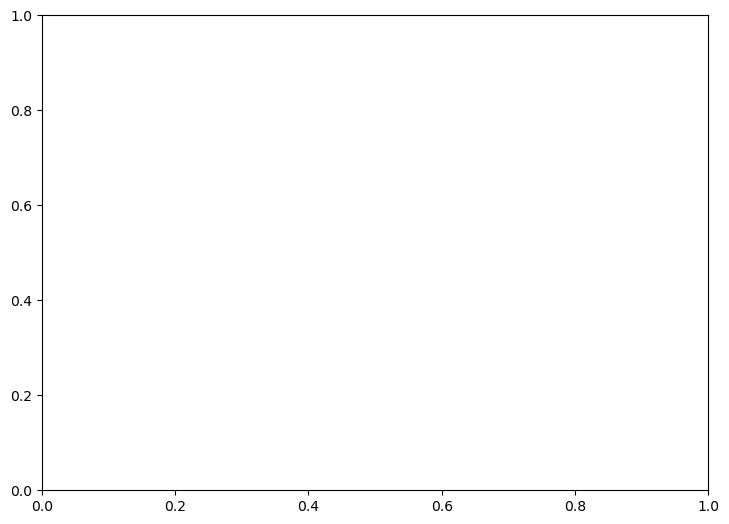

In [25]:
if __name__ == '__main__':
    app = QApplication(sys.argv)
    app.setStyle('Fusion')
    viewer = GrdFileViewer()
    viewer.show()
    sys.exit(app.exec_())